Upload functions and necessary modules

In [1]:
from bb2022_functions import *
%matplotlib inline
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio import SeqIO
pd.options.mode.chained_assignment = None  # default='warn'

Import and format metadata

In [2]:
md = pd.read_csv("metadata_merged.csv")
merged = pd.read_csv("metadata_niskin.csv")
all_md = pd.read_csv("allmetadata.csv")

In [ ]:
d1 = all_md.loc[all_md['depth'] != 30]
d1 = d1.loc[d1['depth'] != 60]
d1 = d1[['weekn', 'depth', 'Phosphate', 'Silicate', 'Nitrate',
       'Ammonia', 'Chlorophyll A']]
d1.rename(columns={'Temperature_x': 'Temperature'},
          inplace= True)
d1 = d1.melt(id_vars=['weekn', 'depth'])

In [ ]:
d60 = all_md.loc[all_md['depth'] != 1]
d60 = d60.loc[d60['depth'] != 5]
d60 = d60.loc[d60['depth'] != 10]
d60 = d60[['weekn', 'depth', 'Phosphate', 'Silicate', 'Nitrate',
       'Ammonia', 'Chlorophyll A']]
d60.rename(columns={'Temperature_x': 'Temperature'},
          inplace= True)

In [ ]:
d60 = d60.melt(id_vars=['weekn', 'depth'])

In [ ]:
nutrients = d1[d1['variable'] != 'Chlorophyll A']
chlorophyll = d1[d1['variable'] == 'Chlorophyll A']

fig, ax1 = plt.subplots(figsize=(15, 7))
sns.lineplot(
    data=nutrients,
    x="weekn", y="value",
    hue='variable', palette='viridis', ax=ax1
)
ax1.set_ylabel("Nutrients (Phosphate, Silicate, Nitrate, Ammonia)")
ax1.legend(title="Nutrients", bbox_to_anchor=(1.05, 1), loc='upper left')

# Second y-axis for Chlorophyll A
ax2 = ax1.twinx()
sns.lineplot(
    data=chlorophyll,
    x="weekn", y="value",
    color='red', label='Chlorophyll A', ax=ax2
)
ax2.set_ylabel("Chlorophyll A")
ax2.legend(title="Chlorophyll A", bbox_to_anchor=(1.05, 0.8), loc='upper left')

# Labels and save
ax1.set_xlabel("Week Number")
plt.title("Nutrients and Chlorophyll A in the euphotic zone (1m, 5m, 10m)")
plt.tight_layout()
plt.savefig("d1_nutrients_chla.png")
plt.show()

In [ ]:
matplotlib.rcParams['figure.figsize'] = 15, 7
sns.lineplot(
    data = d60,
    x="weekn", y="value",
    hue = 'variable', palette = 'viridis'
)
plt.savefig("d60_nutrients.png") 

Add microbial communities

In [14]:
#generate a dataframe from all specified amplicon
df, comm = consolidate_tables('16S') #frac='pooled') #16S, chloroplast, or 18S
merged = merge_metadata(df, all_md)
separated, contaminants = pick_metadata(comm, merged)
newseparated = make_defract(all_md, separated)

Community is 02-PROKs
Found all 16S tables.
Successfully saved all tables.
Set up metadata ...
Saved merged_asvs_metadata.tsv
Appended all taxonomies to taxos
Saved separated by metadata dataframe.
Community is 02-PROKs
Removed cyanobacteria and chloroplast from 02-PROKs


In [4]:
newdf = apply_replacement(newseparated, "feature_id", "Genus")

Values were updated


In [5]:
newdf = apply_replacement(newseparated, "feature_id", "PRSpecies")

Values were updated


In [19]:
forMIMARKS= newseparated[["sampleid", "time_string_x", "size_code", "depth"]].drop_duplicates()
size_fraction_mapping = {
    'L': '>3µm',
    'S': '0.2-3µm',
    'W': '>0.2µm',
    'P': 'Pooled',
    'SL': 'NA'
}

# Create the new column 'size_fraction' based on the mapping
forMIMARKS = forMIMARKS[forMIMARKS['size_code'] != 'SL']
forMIMARKS['size_fraction'] = forMIMARKS['size_code'].map(size_fraction_mapping)
forMIMARKS.to_csv('forMIMARKS.csv', index=False)

In [15]:
# Define a function to calculate Chao1 for a single sample
def calculate_chao1(feature_frequencies):
    """
    Calculate Chao1 estimator for a single sample.
    :param feature_frequencies: List of feature frequencies (counts) for a sample.
    :return: Chao1 richness estimate.
    """
    f1 = sum(1 for count in feature_frequencies if count == 1)  # Number of singletons
    f2 = sum(1 for count in feature_frequencies if count == 2)  # Number of doubletons
    observed_species = len([count for count in feature_frequencies if count > 0])  # Species with non-zero counts
    
    if f2 > 0:
        chao1 = observed_species + (f1 ** 2) / (2 * f2)
    else:
        chao1 = observed_species + f1 * (f1 - 1) / 2
    
    return chao1

data=newseparated[['feature_id', 'sampleid', 'feature_frequency']].copy().drop_duplicates()

In [16]:
#group by sample and calculate chao1
chao1_results = data.groupby('sampleid')['feature_frequency'].apply(calculate_chao1).reset_index()

In [17]:
chao1_results.rename(columns={'feature_frequency': 'chao1'}, inplace=True)
data_with_chao1 = pd.merge(newseparated, chao1_results, on='sampleid')

In [18]:
copy = data_with_chao1[["sampleid", "nASVs", "Total", "chao1", "weekn", "depth", "size_code"]].drop_duplicates()
copy.to_csv(f'R_results/{comm}_selected_columns_forlmms.csv')

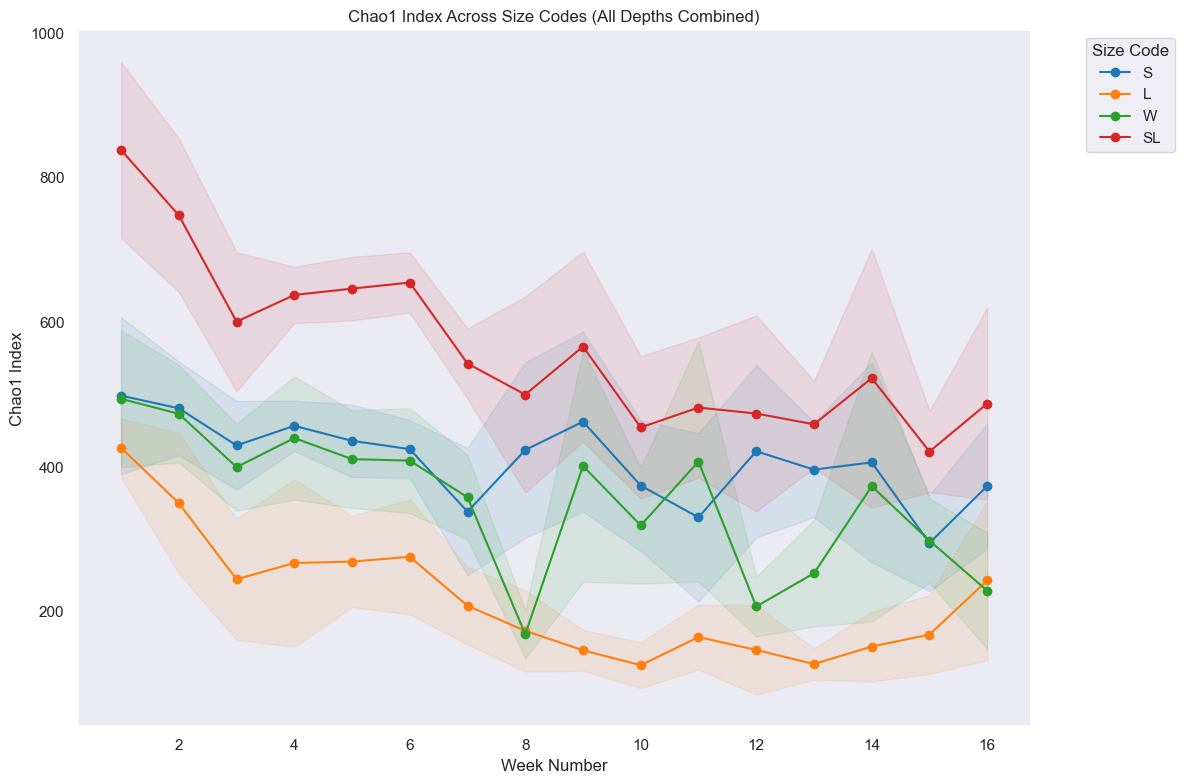

<Figure size 700x200 with 0 Axes>

In [27]:
data = data_with_chao1

if 'SL' in data['size_code'].unique():
    sizecodes = ['S', 'L', 'W', 'SL']
else:
    sizecodes = ['S', 'L', 'W']
    
palette_colors = sns.color_palette("tab10", len(sizecodes))
palette_dict = {sizecode: color for sizecode, color in zip(sizecodes, palette_colors)}

#group data
summary = data.groupby(['weekn', 'size_code']).agg(
    chao1_mean=('chao1', 'mean'),
    chao1_std=('chao1', 'std')  #std
).reset_index()


plt.figure(figsize=(12, 8))

for size_code in sizecodes:
    size_data = summary[summary['size_code'] == size_code]
    
    plt.plot(
        size_data['weekn'], 
        size_data['chao1_mean'], 
        label=size_code, 
        linestyle='-', 
        color=palette_dict[size_code], 
        marker='o'
    )
    
    plt.fill_between( #shaded area for std
        size_data['weekn'], 
        size_data['chao1_mean'] - size_data['chao1_std'], 
        size_data['chao1_mean'] + size_data['chao1_std'], 
        color=palette_dict[size_code], 
        alpha=0.1
    )

sns.set(rc={"figure.figsize":(7, 2)})
plt.xlabel('Week Number')
plt.ylabel('Chao1 Index')
plt.title('Chao1 Index Across Size Codes (All Depths Combined)')
plt.legend(title='Size Code', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)

plt.tight_layout()
plt.show()

plt.savefig(f'outputs/{comm}/chao1.png', transparent=True)

In [ ]:
#plot of dna concentrations per sample
dnacon(newseparated, depth='all')

In [ ]:
#rarefaction curves per community
rarefy_curve(comm, newseparated)

In [ ]:
newseparated[['Total','sampleid']].sort_values('Total').drop_duplicates()

In [ ]:
#taxonomic
phyld, top10d = taxbarplot(comm, newseparated, 'Genus', 5, 10, 'size_code')

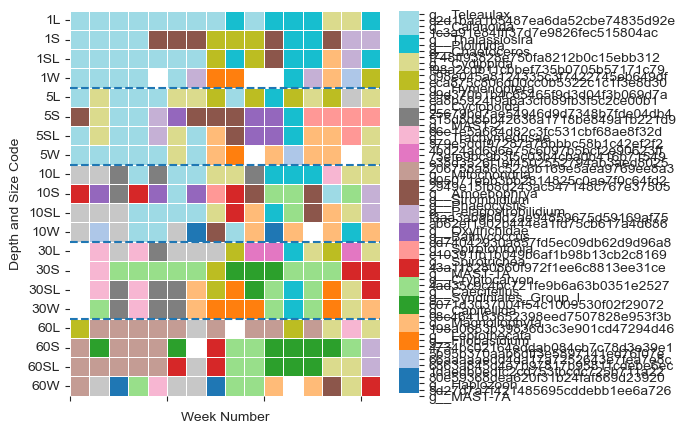

In [5]:
heatmap_top1(comm, newseparated, 'Genus')

In [ ]:
replacement_dict = {
    "A": 100,
    "C": 300
}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


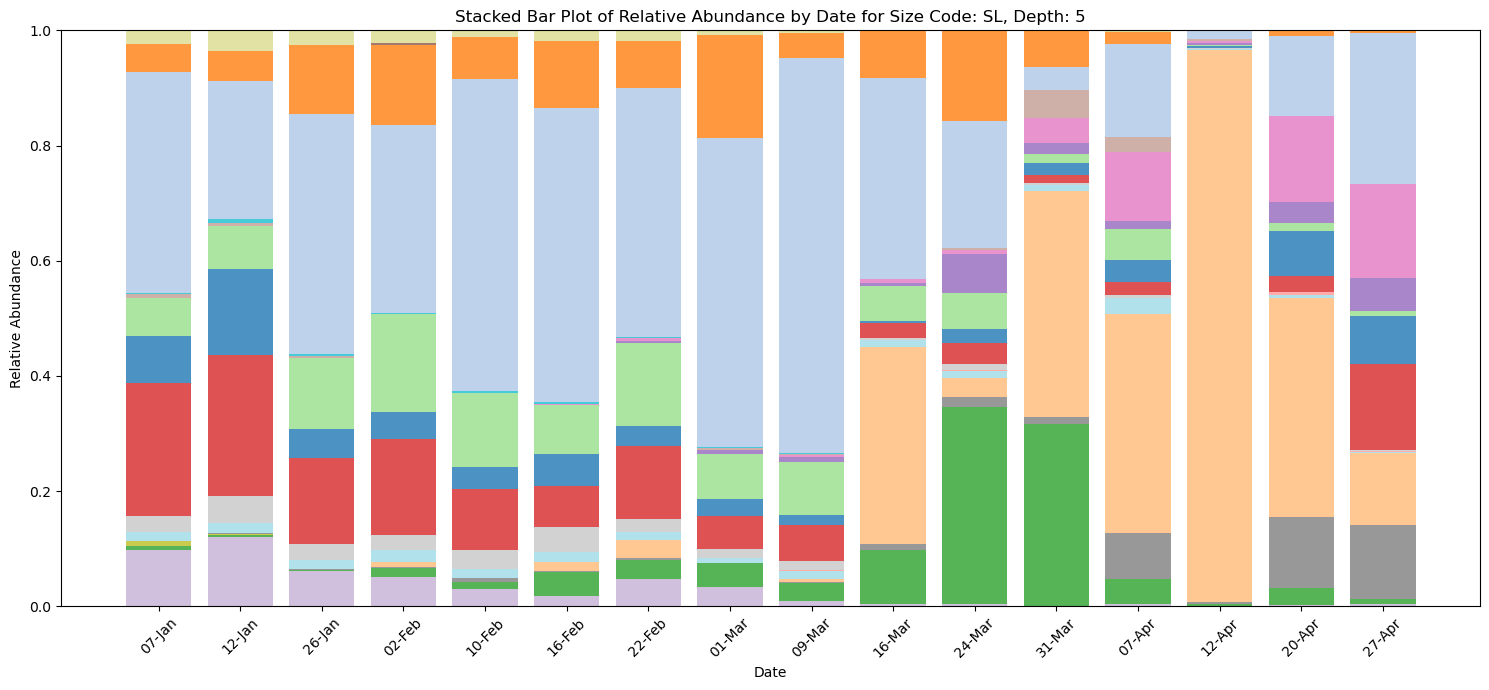

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


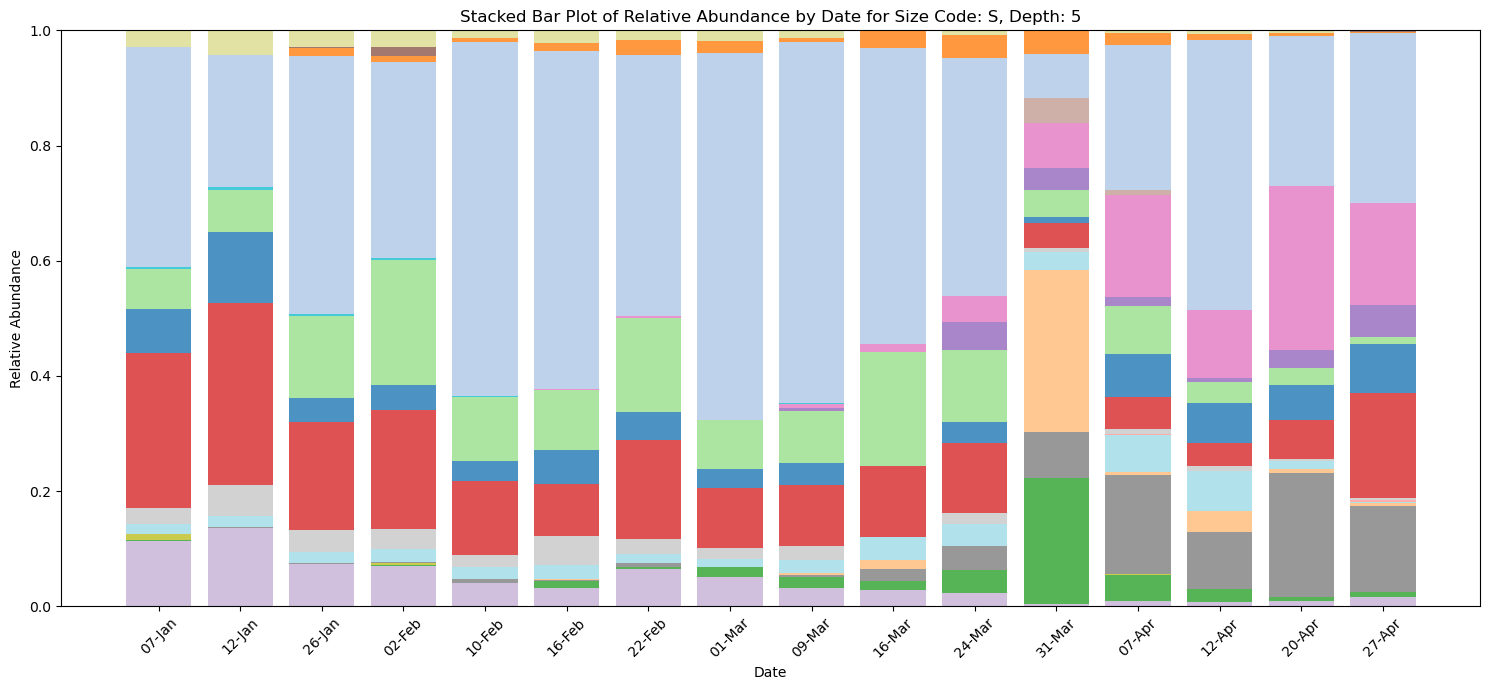

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


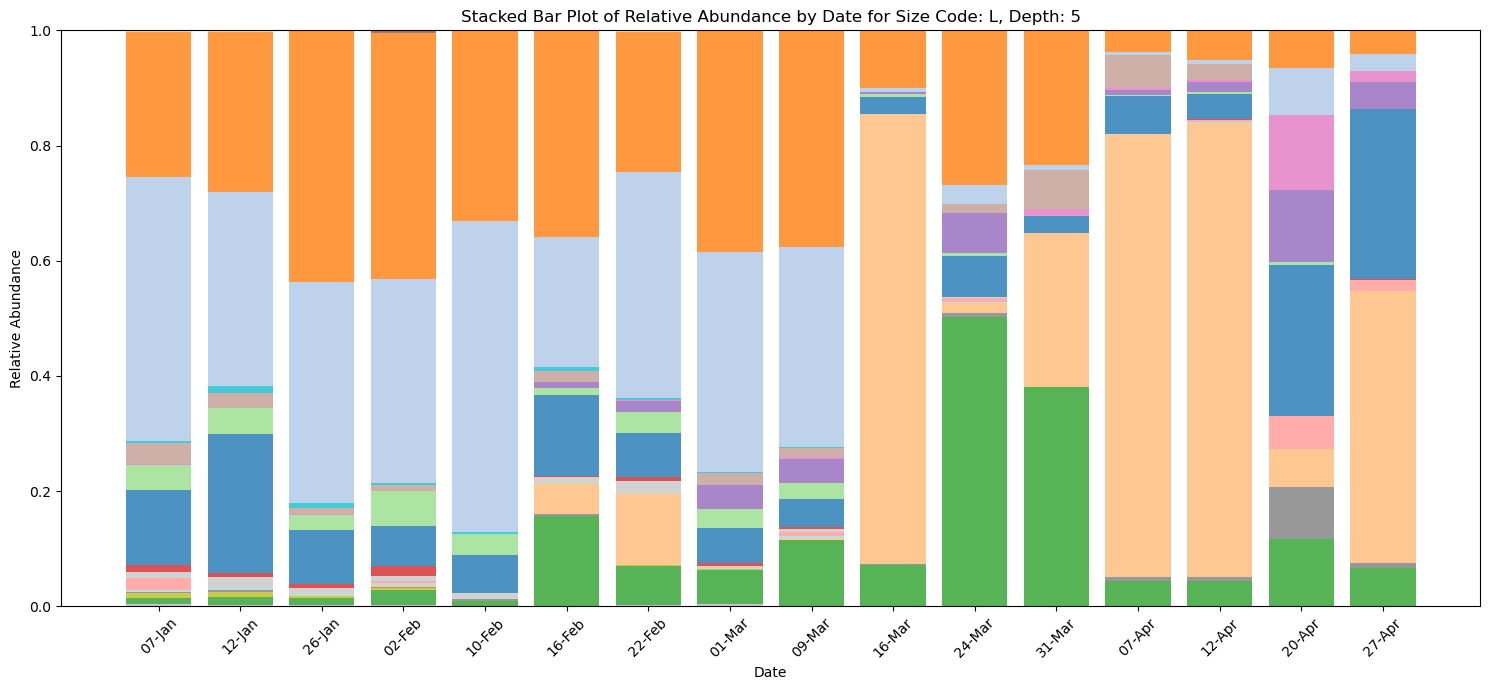

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


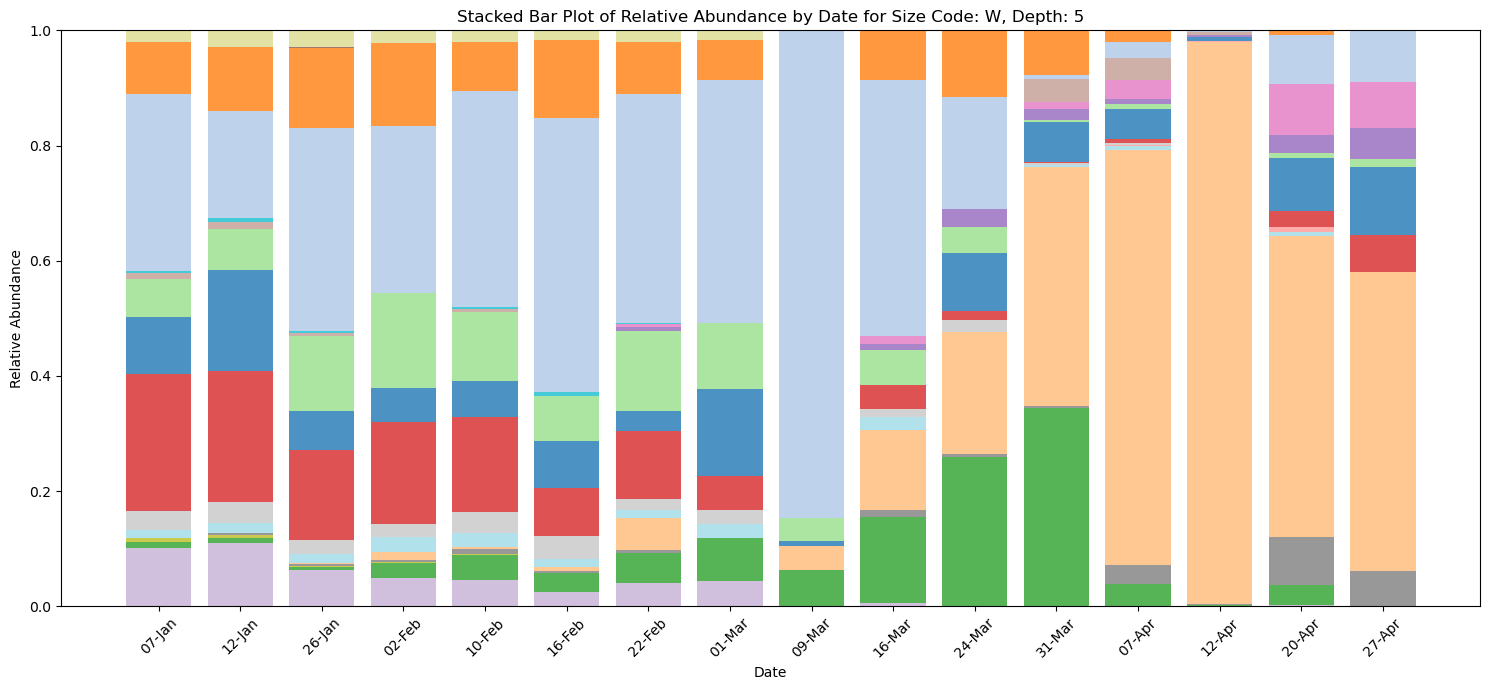

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


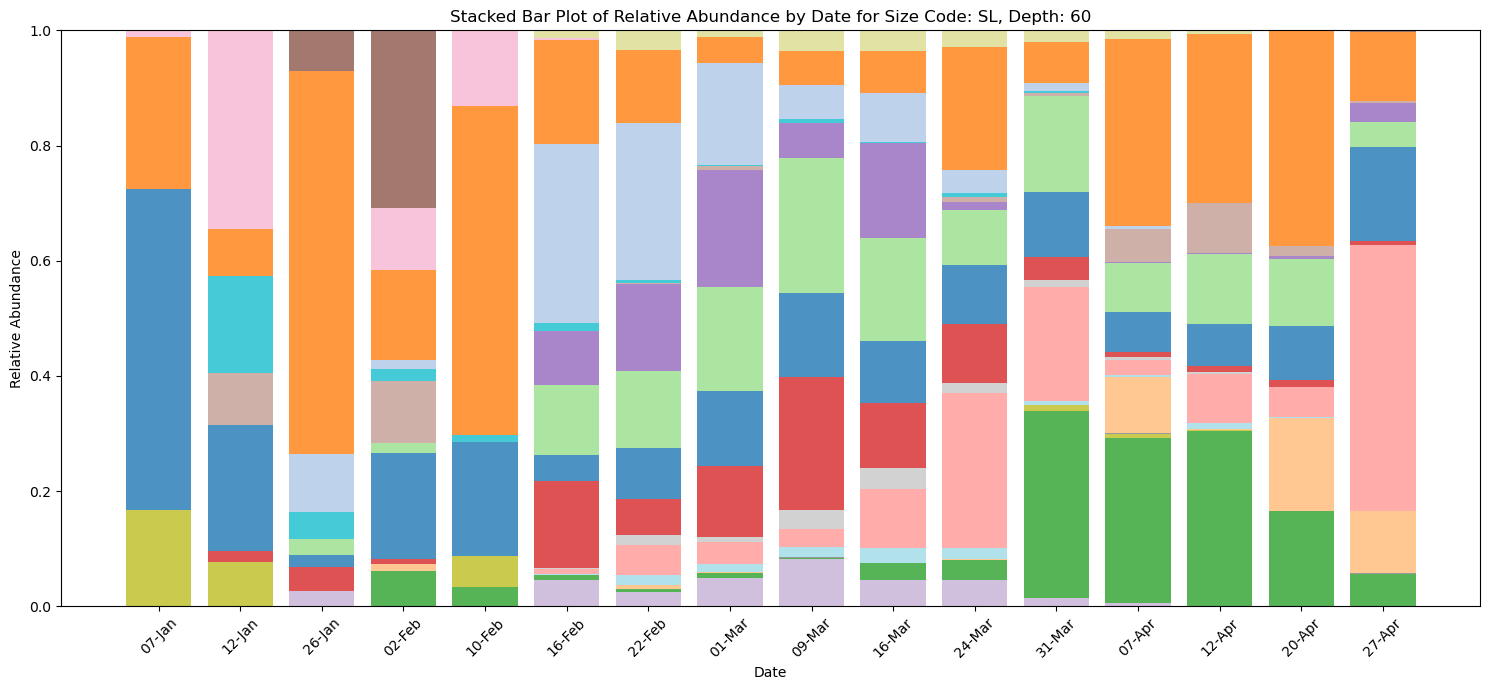

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


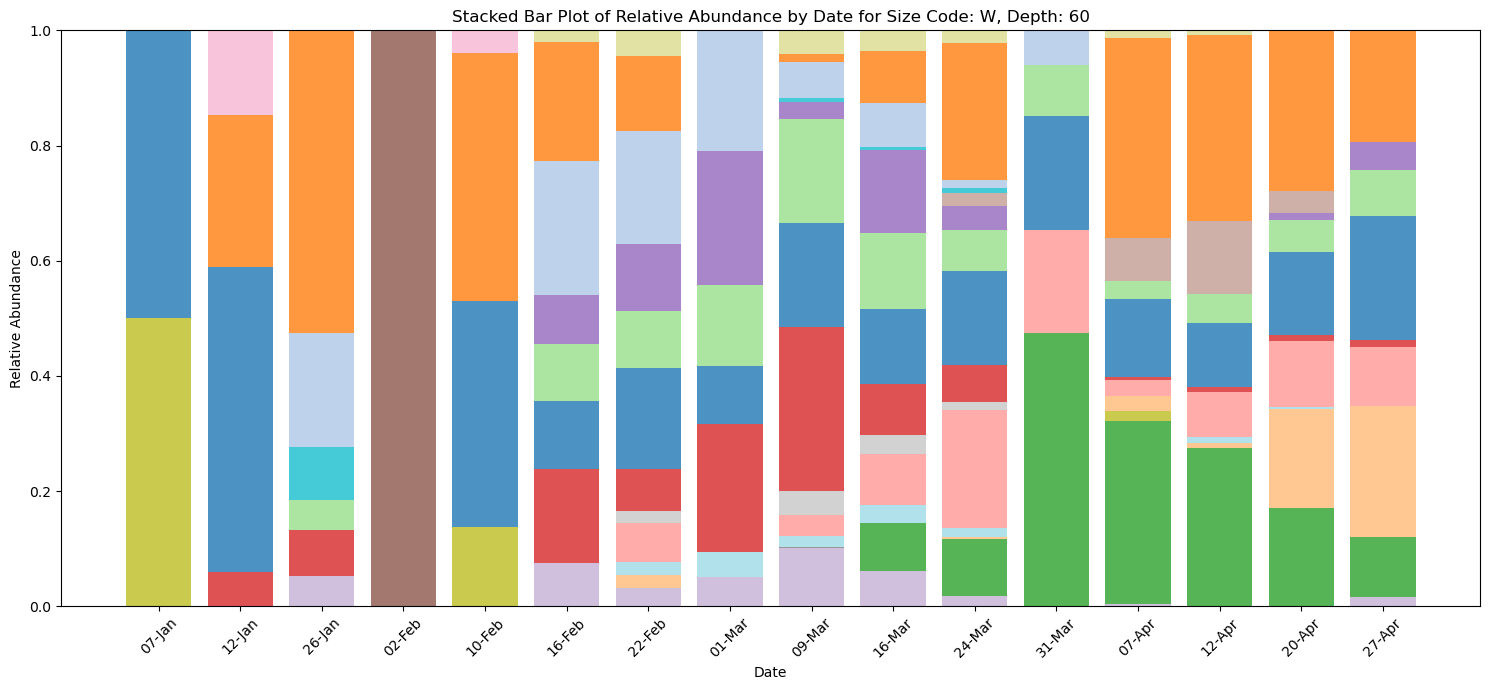

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


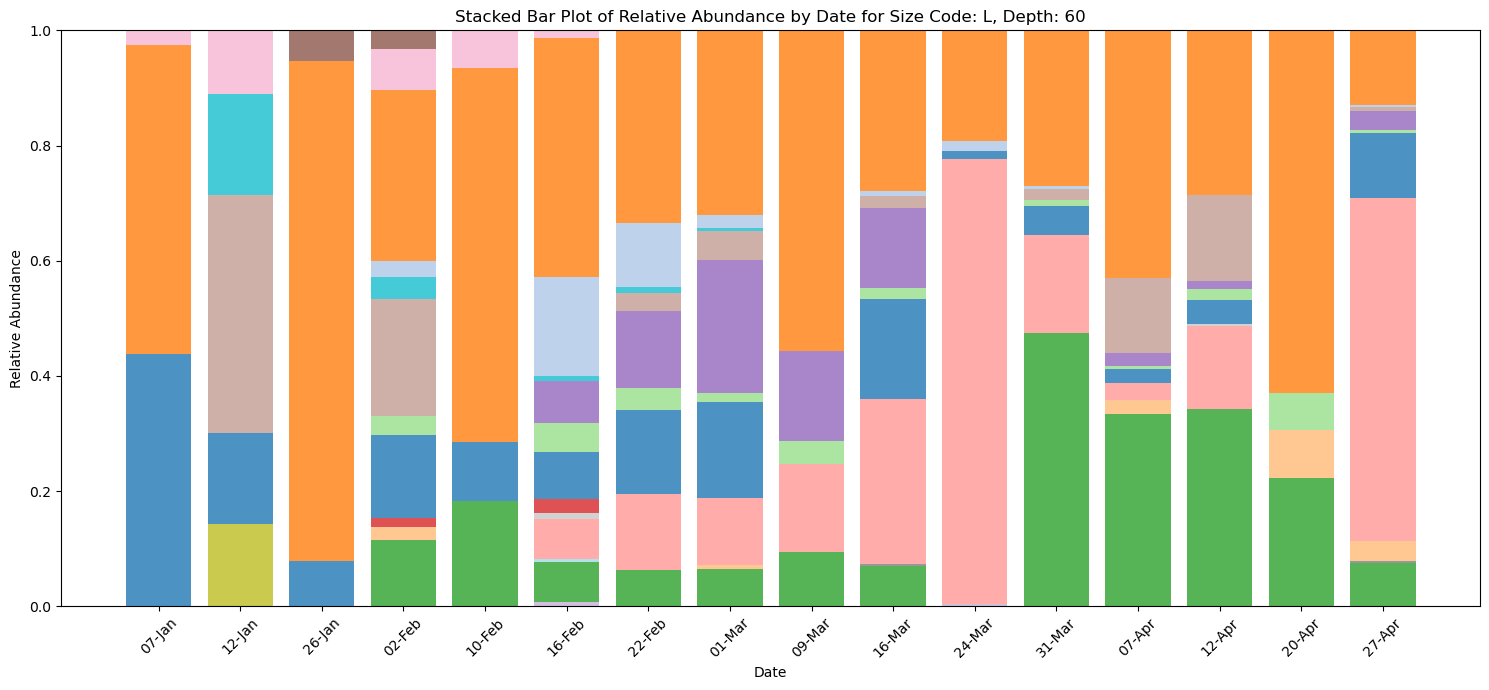

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


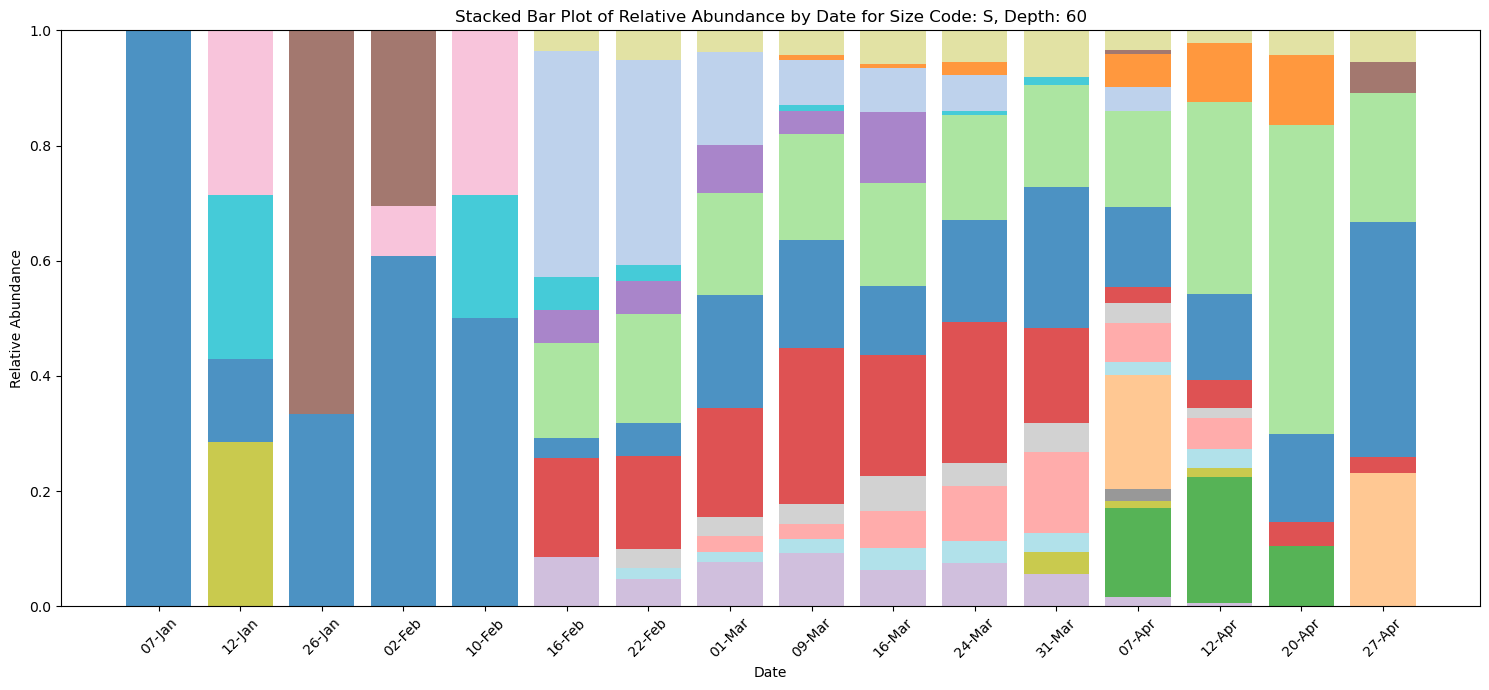

<Figure size 1000x100 with 0 Axes>

In [6]:
taxonomic_barplots(comm, newdf, [5,60], 'PRSpecies', 20)

In [7]:
comm

'chloroplast'

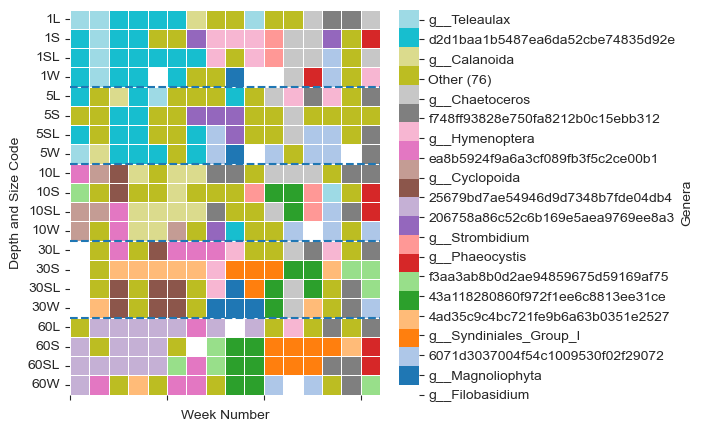

In [8]:
level = 'Genus'
sfd  = newseparated


# Prepare data for top taxa selection
toptaxa = sfd[['feature_id', 'feature_frequency', 'Taxon', 'size_code', 'depth', 'weekn', level]].copy()
toptaxa.loc[toptaxa[level].isin(['Unassigned', 'uncultured+bacterium', 'g__uncultured']), level] = toptaxa['feature_id']

# Drop duplicates
toptaxa = toptaxa.drop_duplicates()

# Aggregate data to find top genera
df_agg = toptaxa.groupby(['size_code', level, 'depth', 'weekn']).agg({'feature_frequency': sum})
topd = df_agg['feature_frequency'].groupby(['size_code', 'depth', 'weekn'], group_keys=False).nlargest(1).reset_index()

# Aggregate rare genera to 'Other'
threshold_frequency = 5  # Set a frequency threshold for aggregating rare genera
genera_counts = topd[level].value_counts()
topd['comm_type'] = topd[level].apply(lambda x: x if genera_counts[x] >= threshold_frequency else 'Other')

# Count the number of 'Other' entries
num_others = (topd['comm_type'] == 'Other').sum()

# Create a dictionary of unique genera with a ranking value assigned automatically
unique_genera = topd['comm_type'].unique()
type_dic = {genus: i for i, genus in enumerate(unique_genera[::-1], start=1)}

# Map 'comm_type' to numerical values
topd['comm_type_numeric'] = topd['comm_type'].map(type_dic)

# Create unique identifier for size_code and depth combinations
topd["sc_weekn"] = topd["depth"].astype(str) + topd["size_code"]

# Sort values
topd = topd.sort_values(['depth', 'size_code'])

# Create a list of unique 'sc_weekn' values
topdlist = topd['sc_weekn'].unique()

# Pivot the DataFrame for the heatmap
glue = topd.pivot(index="sc_weekn", columns="weekn", values="comm_type_numeric")
glue = glue.reindex(topdlist)

# Plotting the heatmap
cmap = plt.get_cmap('tab20', len(type_dic))

sns.set_style('ticks')
plt.figure(figsize=(5, 5))  # Adjusted figure size to original aspect ratio

ax = sns.heatmap(glue, fmt='f', yticklabels=True, linewidths=.5, cmap=cmap, cbar_kws={'label': 'Genera'})

# Add genus names to the colorbar legend
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([val + 0.5 for val in range(len(type_dic))])
colorbar.set_ticklabels([genus if genus != 'Other' else f'Other ({num_others})' for genus in unique_genera[::-1]])

ax.axhline(4, ls='--')
ax.axhline(8, ls='--')
ax.axhline(12, ls='--')
ax.axhline(16, ls='--')

ax.set_xticks(range(0, 16, 5))
ax.set_ylabel("Depth and Size Code")
ax.set_xlabel("Week Number")

plt.savefig(f'outputs/{comm}/heatmap_top1_{level}.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
tohm, z_sc_df = get_slopes(comm, separated)
#a zscore of 1= 1 std away from the mean,
#positive values=higher than mean, neg= smaller than mean

In [ ]:
grab_80perc(comm, newseparated, 0.8, 'feature_id')

In [ ]:
#run the visualisations for alpha diversity and run pairwise t-tests between size fractions for richness values
anova, results = boxplot_depth(newseparated, comm, 60, 'nASVs', 'Number of ASVs')

ANCOM analysis

In [ ]:
#create a new df where we remove the low abundance ASVs
news2 = newseparated.drop(newseparated[(newseparated['ratio'] <0.05 )].index)

#re-calculate ratios when removing chloroplast for 16S
news2['Total'] = news2['feature_frequency'].groupby(news2['sampleid']).transform('sum')
news2['ratio'] = news2['feature_frequency']/news2['Total']

In [ ]:
#only if we want to run ANCOM pairwise
news2 = newseparated[newseparated.size_code != 'L']
news2 = news2[news2.size_code != 'SL']

In [ ]:
depths = [1,5,10,30,60]
for depth in depths:
    pca, pca_features, sfdclr, dm = pcaplot(newseparated, depth, comm, 'size_code', 'DFr', 'week')
    DAresults, DARejected_SC_taxonomy, prcentile = run_ancom(comm, newseparated, sfdclr, depth, 'size_code')

    #save outputs
    DAresults.to_csv('outputs/ANCOM/chloroplast/none/'+comm+'_D'+str(depth)+'_WSLSL.csv')
    DARejected_SC_taxonomy.to_csv('outputs/ANCOM/chloroplast/none/'+comm+'_D'+str(depth)+'_Trueonly_WSLSL.csv')

    notify()

In [7]:
f_id = 'ec0cef5115e1a5e72ba718c19f44ac1e'
newdf.loc[newdf['feature_id'] == f_id, 'Taxon'].tolist()[0]

'd__Eukaryota; p__Dinoflagellata; c__Dinophyceae; o__Gymnodiniphycidae; f__Gymnodiniphycidae'

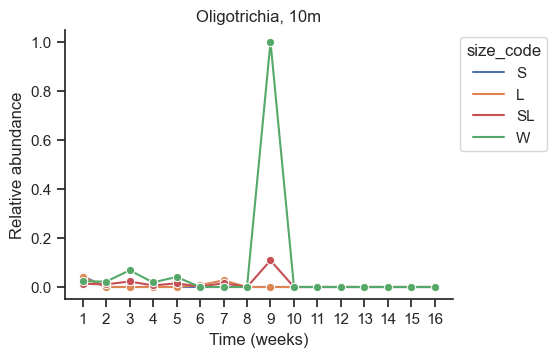

In [41]:
timeseries_fid(comm, newseparated, f_id, 'Oligotrichia', 10)

In [ ]:
feature_id_summary = count_feature_id_presence_with_depth_and_W('outputs', comm)
top_asvs_summary = filter_top_asvs(feature_id_summary, method="top_W_sum", n=50)
plot_asv_heatmap(comm, feature_id_summary, file_filter="WSLSL")

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

def plot_asv_heatmap(comm, feature_id_summary, newseparated, file_filter=None, directory_path=None, n_asvs=50):
    """
    Plots a heatmap of W values for ASVs across depths, with the highest size fraction label (W, S, L, SL) annotated in each cell.

    Args:
    - comm: The community type, which is used to specify the directory for input files.
    - feature_id_summary: The feature summary generated by count_feature_id_presence_with_depth_and_W.
    - newseparated: The DataFrame containing "size_code", "feature_id", "ratio", and "depth" columns.
    - file_filter: Optional string to filter the filenames considered (e.g., "WSLSL" or "WSL").
                   If None, all files are considered.
    - directory_path: Optional base directory for locating the ANCOM files.
    - n_asvs: The number of ASVs to include in the heatmap.

    Returns:
    - None (displays the heatmap)
    """
    # Filter top ASVs based on selected method and given number
    top_asvs_summary = filter_top_asvs(feature_id_summary, method="top_W_sum", n=n_asvs)

    # Preparing data for heatmap
    depths = ["Depth_1", "Depth_5", "Depth_10", "Depth_30", "Depth_60"]
    w_values_dict = {}
    fraction_labels_dict = {}

    for entry in top_asvs_summary:
        feature_id, _, entry_depths, files, _ = entry

        # Determine the taxonomic label based on community type
        taxonomic_label = feature_id  # Default to feature_id if no taxonomic assignment is found
        if comm == 'chloroplast':
            # Get taxonomic assignment from `newseparated` DataFrame for chloroplast
            filtered_taxon_data = newseparated[newseparated['feature_id'] == feature_id]
            if not filtered_taxon_data.empty:
                prtaxon = filtered_taxon_data['PRTaxon'].values[0] if 'PRTaxon' in filtered_taxon_data.columns else None
                if pd.notna(prtaxon):
                    levels = prtaxon.split('|')
                    last_identified = levels[-1]
                    if last_identified in ["Unassigned", "N/A", "", "unidentified"] and len(levels) > 1:
                        last_identified = levels[-2]
                    taxonomic_label = last_identified
        else:
            # For non-chloroplast data, get taxonomic labels from `newseparated` DataFrame
            filtered_taxon_data = newseparated[newseparated['feature_id'] == feature_id]
            if not filtered_taxon_data.empty:
                genus = filtered_taxon_data['Genus'].values[0] if 'Genus' in filtered_taxon_data.columns else None
                species = filtered_taxon_data['Species'].values[0] if 'Species' in filtered_taxon_data.columns else None
                family = filtered_taxon_data['Family'].values[0] if 'Family' in filtered_taxon_data.columns else None
                taxon = filtered_taxon_data['Taxon'].values[0] if 'Taxon' in filtered_taxon_data.columns else None

                # Normalize values for comparison
                def normalize_taxonomic_label(label):
                    return label if pd.notna(label) and label not in ["Unassigned", "N/A", "", "unidentified"] else None

                genus = normalize_taxonomic_label(genus)
                species = normalize_taxonomic_label(species)
                family = normalize_taxonomic_label(family)

                # Assign taxonomic label based on the given preference
                if species and genus:
                    taxonomic_label = f"{genus} {species}"
                elif genus:
                    taxonomic_label = genus
                elif family:
                    genus_label = genus if genus else "unidentified"
                    taxonomic_label = f"{family} ({genus_label})"
                elif taxon:
                    levels = taxon.split('; ')
                    last_identified = ""
                    next_unassigned = ""
                    for i, level in enumerate(levels):
                        if level.split("__")[1] not in ["Unassigned", "N/A", "", "unidentified"]:
                            last_identified = level
                        else:
                            next_unassigned = level
                            break
                    if last_identified:
                        taxonomic_label = f"{last_identified}; {next_unassigned}" if next_unassigned else last_identified

        # Create dictionary to hold W values and size fraction label for each depth
        w_values_per_depth = {depth: 0 for depth in depths}
        highest_fraction_label_per_depth = {depth: "" for depth in depths}

        # Loop through files to accumulate W values per depth
        for file_path in files:
            # Apply file filter condition if specified
            if file_filter and file_filter not in file_path:
                continue

            # Adjust the file path to include the community subdirectory
            if directory_path:
                full_file_path = os.path.join(directory_path, 'ANCOM', comm, os.path.basename(file_path))
            else:
                full_file_path = file_path

            # Extract depth from the file name
            depth_match = re.search(r"_D(1|5|10|30|60)_", full_file_path)
            if depth_match:
                depth = f"Depth_{depth_match.group(1)}"
            else:
                continue  # Skip files without depth information

            # Load the CSV to extract W value for the specific feature ID
            try:
                df = pd.read_csv(full_file_path)
                if 'feature_id' in df.columns and 'W' in df.columns:
                    w_value_sum = df[df['feature_id'] == feature_id]['W'].sum()
                    w_values_per_depth[depth] += w_value_sum
            except Exception as e:
                print(f"Error reading file {full_file_path}: {e}")

        # Determine the size fraction with the highest abundance ratio using `newseparated`
        for depth in depths:
            filtered_data = newseparated[
                (newseparated['feature_id'] == feature_id) &
                (newseparated['depth'] == int(depth.split('_')[1]))
            ]

            if not filtered_data.empty:
                highest_ratio_row = filtered_data.loc[filtered_data['ratio'].idxmax()]
                highest_fraction_label = highest_ratio_row['size_code']
                highest_fraction_label_per_depth[depth] = highest_fraction_label

        # Store the W values and size fraction labels for each depth under the corresponding taxonomic label
        w_values_dict[taxonomic_label] = w_values_per_depth
        fraction_labels_dict[taxonomic_label] = highest_fraction_label_per_depth

    # Creating DataFrame for W values and fraction labels
    w_values_df = pd.DataFrame(w_values_dict).T  # Transpose to have taxonomic labels as rows
    w_values_df.columns = depths
    heatmap_labels_df = pd.DataFrame(fraction_labels_dict).T
    heatmap_labels_df.columns = depths

    # Plotting the heatmap with W values and labels for size fractions
    plt.figure(figsize=(15, 10))
    ax = sns.heatmap(w_values_df, cmap="YlGnBu", annot=False, linewidths=0.5, cbar_kws={'label': 'Sum of W Values per Depth'})

    # Annotate each cell with the corresponding size fraction label
    for y in range(heatmap_labels_df.shape[0]):
        for x in range(heatmap_labels_df.shape[1]):
            label = heatmap_labels_df.iloc[y, x]
            w_value = w_values_df.iloc[y, x]
            if not pd.isna(label) and w_value > 0:
                ax.text(x + 0.5, y + 0.5, label, ha='center', va='center', fontsize=10, color='black')

    # Adding labels and title
    plt.xlabel("Depth")
    plt.ylabel("Taxonomic Assignments (Genus, Species, or Family)")
    plt.title("Heatmap of W Values with Highest Size Fraction Label per Depth")
    plt.tight_layout()

    # Save the plot
    plt.savefig('outputs/' + comm + '/ancom_heatmap_plot_withSC.png', dpi=300)  # Save the plot to a file

    # Show the plot
    plt.show()


NameError: name 'unique_weeks' is not defined

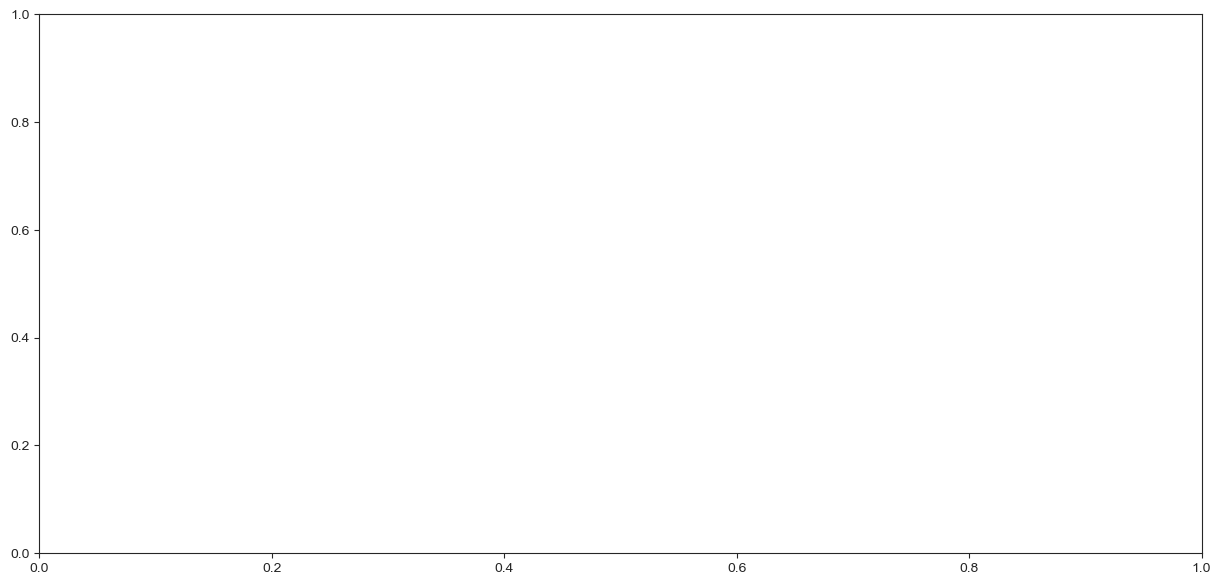

In [10]:
# Plot
fig, ax1 = plt.subplots(figsize=(15, 7))

# Grouped bar plot for taxonomic composition
x = np.arange(len(unique_weeks))  # Position for bars
bar_width = 0.2  # Width of each bar
colors = plt.cm.tab20(np.linspace(0, 1, len(taxa_categories)))  # Assign unique colors to taxa

for i, size_code in enumerate(size_codes):
    size_data = phyld_pivot.loc[(slice(None), size_code), :].reset_index(level='size_code', drop=True)
    for j, taxon in enumerate(taxa_categories):
        ax1.bar(
            x + i * bar_width, 
            size_data[taxon], 
            bar_width, 
            color=colors[j],
            alpha=0.8
        )

# Customize x-axis for grouped bars
ax1.set_xticks(x + bar_width * (len(size_codes) - 1) / 2)
ax1.set_xticklabels(unique_weeks)
ax1.set_ylabel("Relative Abundance")
ax1.set_xlabel("Week Number")

# Update legend to show taxa and their colors
taxa_legend = [plt.Line2D([0], [0], color=colors[j], lw=4, label=taxon) for j, taxon in enumerate(taxa_categories)]
ax1.legend(handles=taxa_legend, title="Taxa", bbox_to_anchor=(1.05, 1), loc='upper left')

# Line plot for shared nutrients and Chlorophyll A
ax2 = ax1.twinx()
sns.lineplot(
    data=nutrient_data_combined,
    x="weekn", y="Concentration", hue="Nutrient", style="Nutrient",
    palette="viridis", markers=True, ax=ax2
)
ax2.set_ylabel("Nutrients (μmol/L)/Chlorophyll A (μg/L) Concentration")
ax2.legend(title="Nutrients", bbox_to_anchor=(1.05, 0.8), loc='upper left')

plt.title("Grouped Taxonomic Composition and Shared Nutrient Dynamics")
plt.tight_layout()
plt.show()


In [37]:
comm

'chloroplast'

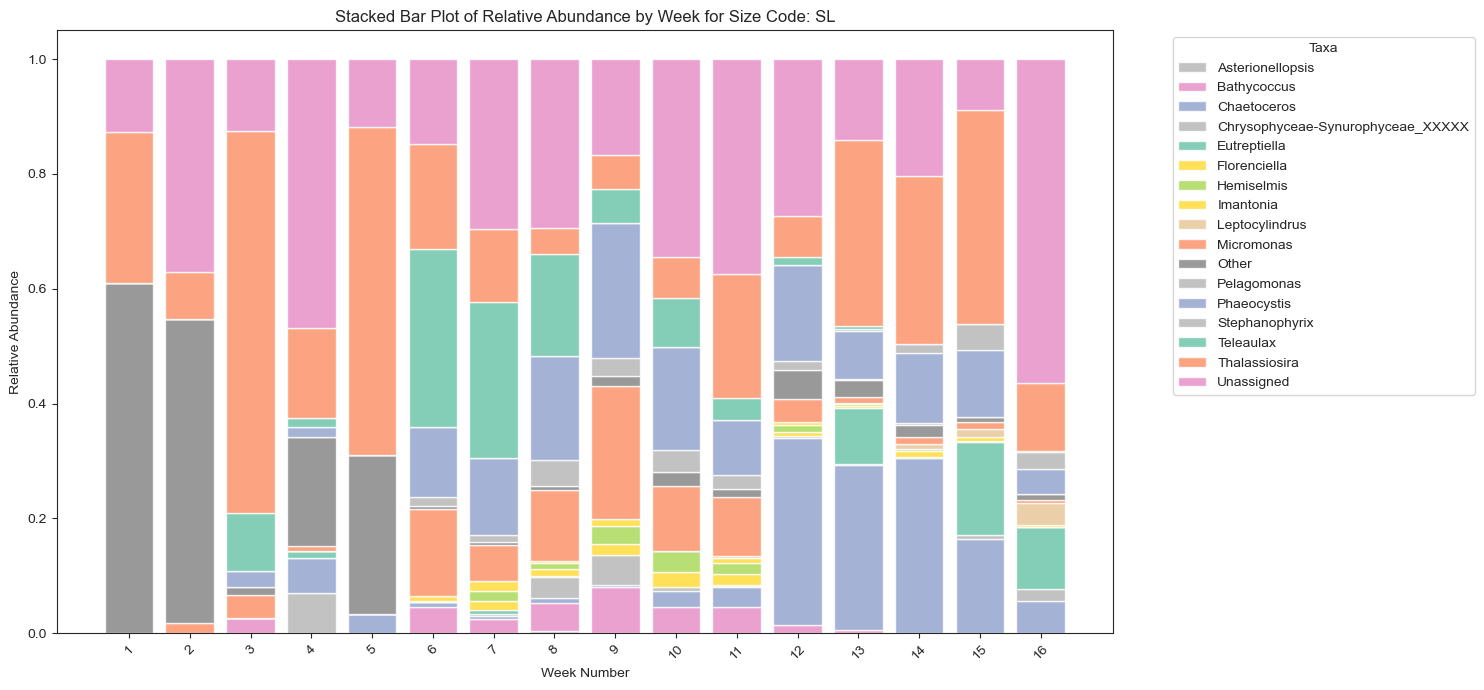

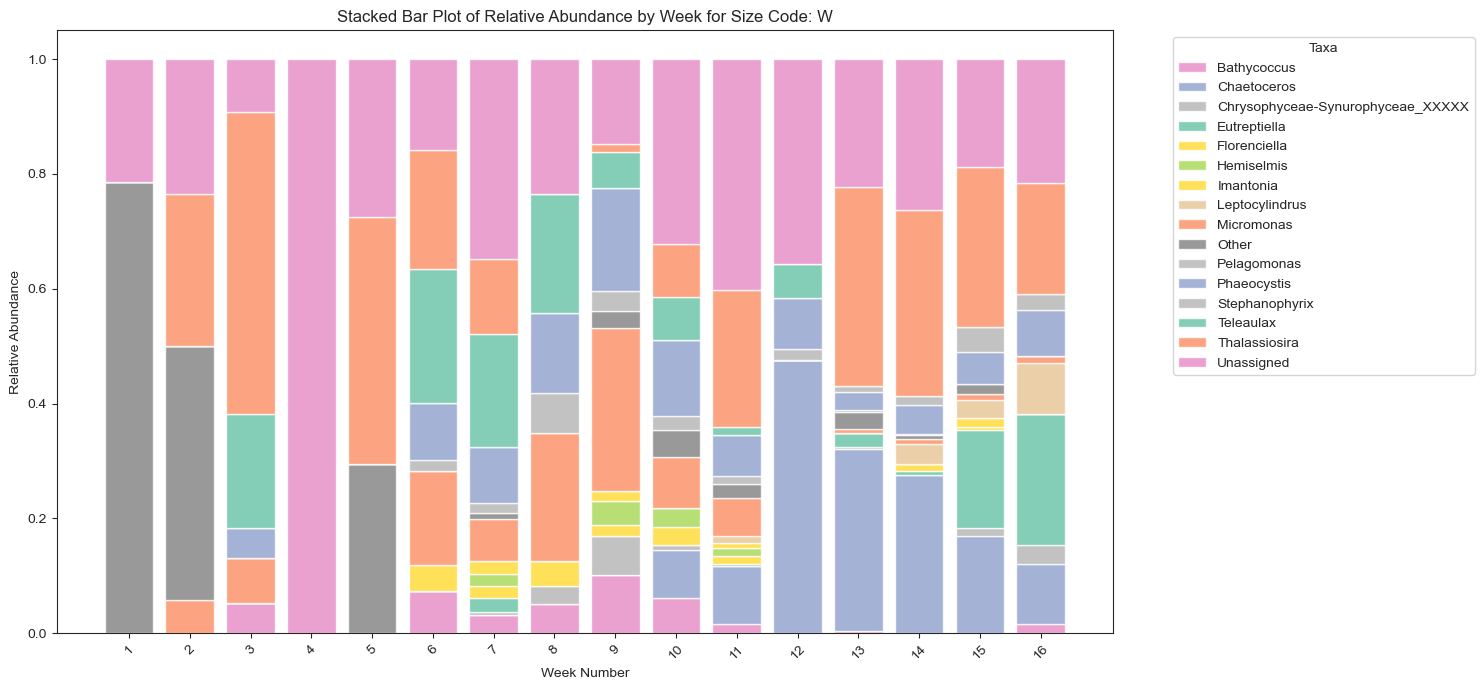

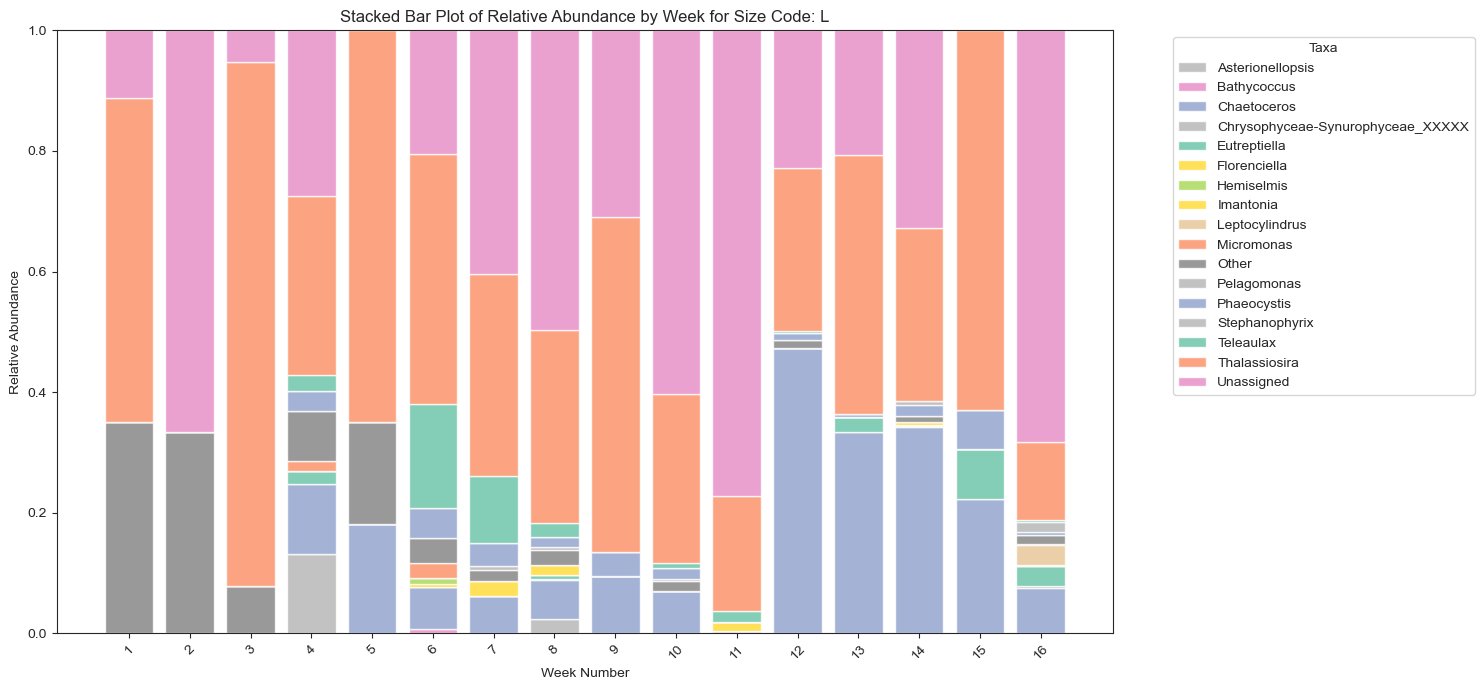

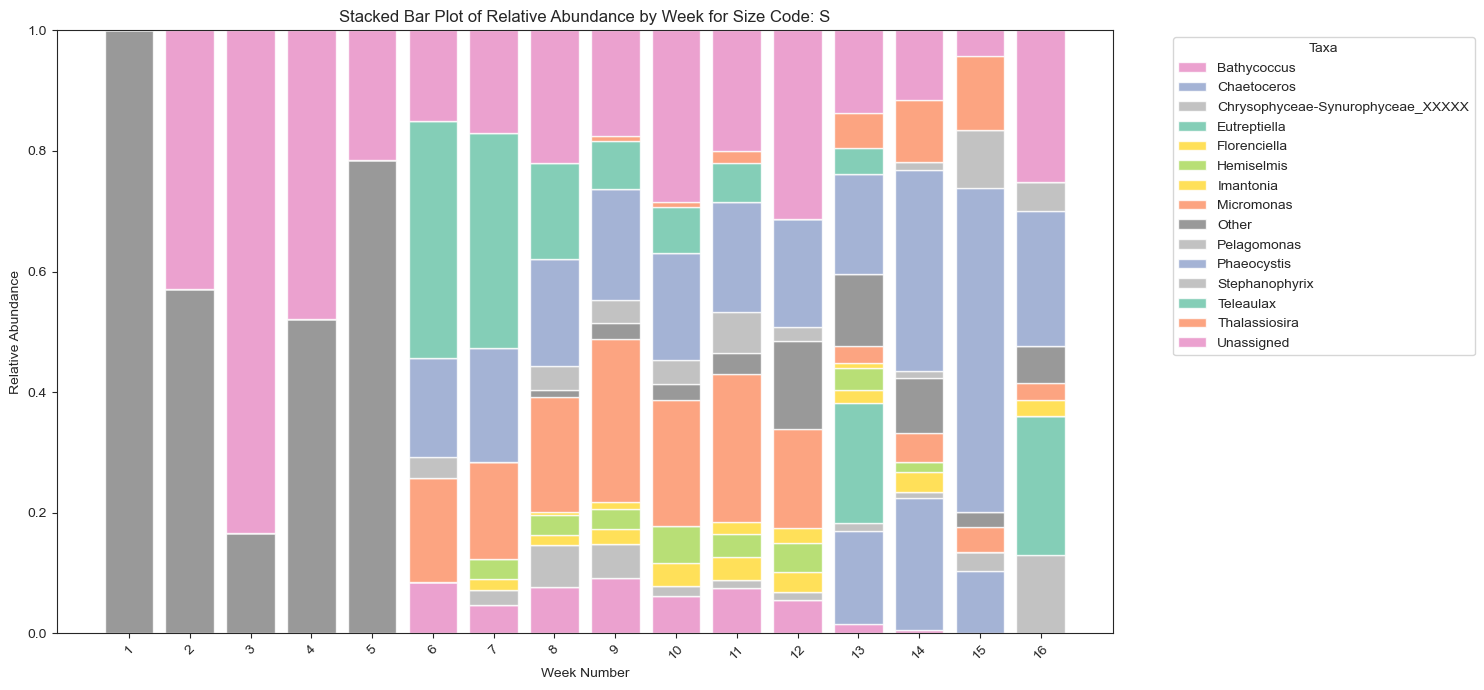

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Assuming 'newseparated' DataFrame has been loaded with columns 'size_code', 'depth', 'Taxon', 'weekn', 'Class', 'ratio'

depth = 60
topn = 10
level = 'Class'

if comm == 'chloroplast':
    level = 'PRSpecies'

# Filter data for the specific depth
sfd = newseparated[newseparated['depth'] == depth]

# Prepare data for top taxa selection
toptaxa = sfd[['feature_frequency', 'Taxon', 'size_code', 'depth', 'weekn', 'date', level]].drop_duplicates()
df_agg = toptaxa.groupby(['size_code', level, 'depth']).agg({'feature_frequency': sum})

topd = df_agg['feature_frequency'].groupby('size_code', group_keys=False).nlargest(topn).reset_index()

df_agg = df_agg.reset_index()
df_agg['set_name'] = df_agg['size_code'] + df_agg['depth'].astype(str)

# Prepare cumulative abundance data for plotting
cumulab = newseparated[['feature_frequency', 'depth', 'size_code', level]].copy()
cumulab1 = cumulab.groupby([level]).agg({'feature_frequency': sum})


# Use a continuous colormap like viridis to assign unique colors
n_taxa = len(top10d_list)
color_palette = cm.get_cmap('Set2', n_taxa)  # Use 'viridis' with as many colors as unique taxa
color_dict = {taxon: color_palette(i) for i, taxon in enumerate(unique_taxa)}

# Create stacked bar plots for each size_code
size_codes = sfd['size_code'].unique()

top10d_list = topd[level].unique()

for size_code in size_codes:
    # Filter data for the current size_code
    top10d = sfd[sfd['size_code'] == size_code].copy()
    top10d.loc[~top10d[level].isin(top10d_list), level] = 'Other'
    phyld = top10d.groupby(['weekn', level])['ratio'].sum().reset_index()
    
    # Pivot the DataFrame to prepare for stacked bar plotting
    phyld_pivot = phyld.pivot(index='weekn', columns=level, values='ratio').fillna(0).reset_index()
    
    # Determine x positions based on unique week numbers
    week_numbers = phyld_pivot['weekn'].unique()
    x = np.arange(len(week_numbers))  # Positions for bars

    # Initialize stack heights
    bottom_stack = np.zeros(len(x))

    # Initialize the plot
    fig, ax1 = plt.subplots(figsize=(15, 7))

    # Iterate over each taxon and stack their relative abundances
    taxa_categories = phyld_pivot.columns[1:]  # Skip 'weekn'
    for taxon in taxa_categories:
        # Aggregate taxon values by week
        heights = phyld_pivot.groupby('weekn')[taxon].sum().reindex(week_numbers, fill_value=0).values

        # Plot the stacked bar for this taxon
        ax1.bar(
            x,  # X positions
            heights,  # Heights of the bars
            bottom=bottom_stack,  # Start at the current stack height
            label=taxon,  # Taxon name for the legend
            alpha=0.8,
            color=color_dict.get(taxon, 'gray')  # Use color from dictionary or default to gray
        )
        # Update the stack height
        bottom_stack += heights

    # Customize x-axis
    ax1.set_xticks(x)
    ax1.set_xticklabels(week_numbers, rotation=45)
    ax1.set_ylabel("Relative Abundance")
    ax1.set_xlabel("Week Number")

    # Add a legend for the taxa
    ax1.legend(title="Taxa", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.title(f"Stacked Bar Plot of Relative Abundance by Week for Size Code: {size_code}")
    plt.tight_layout()
    plt.savefig(f'stacked_bar_plot_size_code_{size_code}_{depth}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
table = newseparated
depth= 5
topn= 10
level='Class'

sfd=table[table.depth==depth]
toptaxa = sfd[['feature_frequency', 'Taxon', 'size_code', 'depth','weekn', level]].copy()
toptaxa = toptaxa.drop_duplicates()
df_agg = toptaxa.groupby(['size_code',level, 'depth']).agg({'feature_frequency':sum})
topd = df_agg['feature_frequency'].groupby('size_code', group_keys=False).nlargest(topn)
topd = topd.to_frame()
topd = topd.reset_index()


df_agg = df_agg.reset_index()
df_agg['set_name'] = df_agg['size_code']+df_agg['depth'].astype(str)

cumulab = separated[['feature_frequency', 'depth', 'size_code', level]].copy()
cumulab1 = cumulab.groupby([level]).agg({'feature_frequency':sum})

resultpivot = df_agg.pivot_table(index=level, columns='set_name', values='feature_frequency')
resultpivot = resultpivot.fillna(0)
resultpivot[resultpivot != 0] = 1
tosave = pd.merge(resultpivot, cumulab1, left_index=True, right_index=True)
tosave.to_csv('outputs/'+comm+'/relab'+level+'_'+str(depth)+'.csv')

top10d_list = topd[level].unique()
top10d = sfd.copy()
top10d.loc[~top10d[level].isin(top10d_list), level] = 'Other' #isnot in top list
phyld = top10d.groupby(['size_code','weekn', level])['ratio'].sum()
phyld = phyld.reset_index()
# Flatten phyld_pivot for easier handling
phyld_pivot = phyld_pivot.reset_index()

# Determine x positions based on unique week numbers
week_numbers = phyld_pivot['weekn'].unique()
x = np.arange(len(week_numbers))  # Positions for bars


# Initialize stack heights
bottom_stack = np.zeros(len(x))

# Initialize the plot
fig, ax1 = plt.subplots(figsize=(15, 7))

# Iterate over each taxon and stack their relative abundances
for taxon in taxa_categories:
    if taxon in phyld_pivot.columns:
        # Aggregate taxon values by week
        heights = phyld_pivot.groupby('weekn')[taxon].sum().reindex(week_numbers, fill_value=0).values

        # Plot the stacked bar for this taxon
        ax1.bar(
            x,  # X positions
            heights,  # Heights of the bars
            bottom=bottom_stack,  # Start at the current stack height
            label=taxon,  # Taxon name for the legend
            alpha=0.8
        )
        # Update the stack height
        bottom_stack += heights

# Customize x-axis
ax1.set_xticks(x)
ax1.set_xticklabels(week_numbers, rotation=45)
ax1.set_ylabel("Relative Abundance")
ax1.set_xlabel("Week Number")

# Add a legend for the taxa
ax1.legend(title="Taxa", bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.title("Stacked Bar Plot of Relative Abundance by Week")
plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


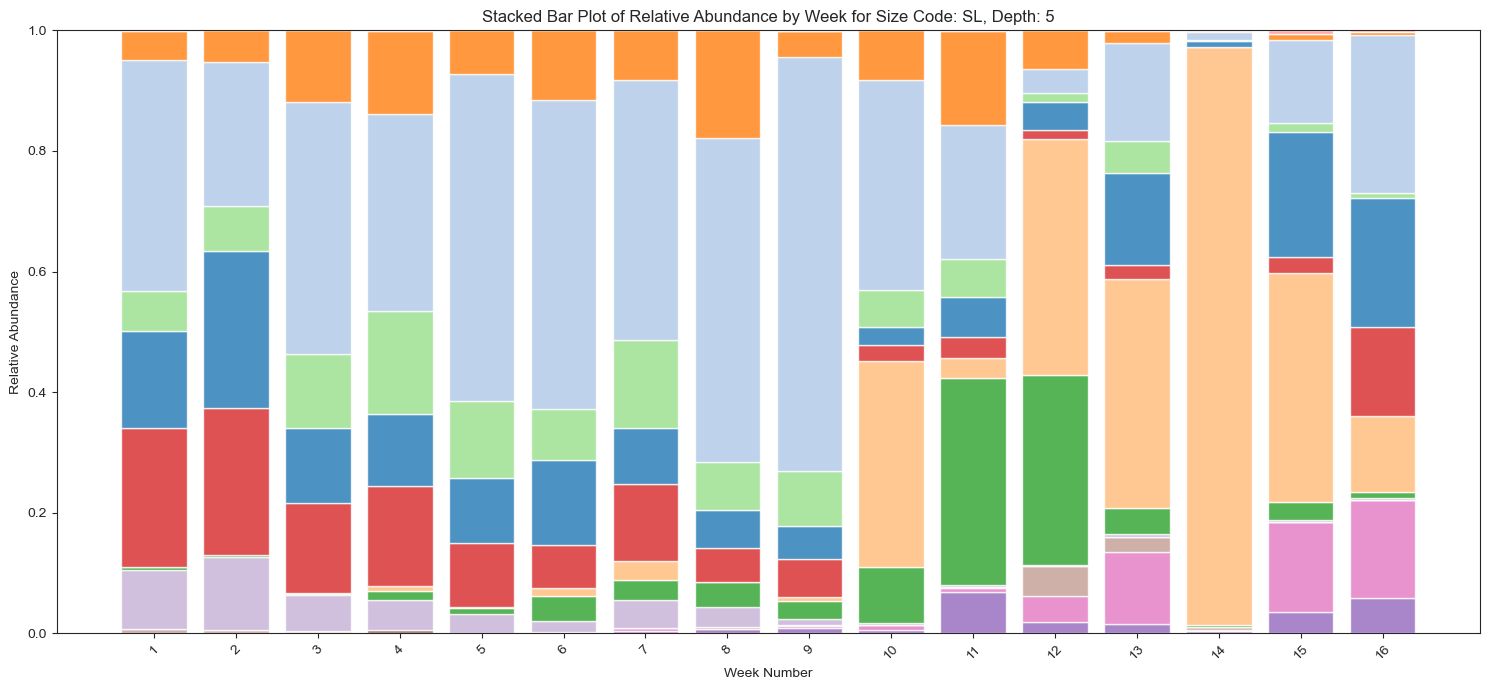

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


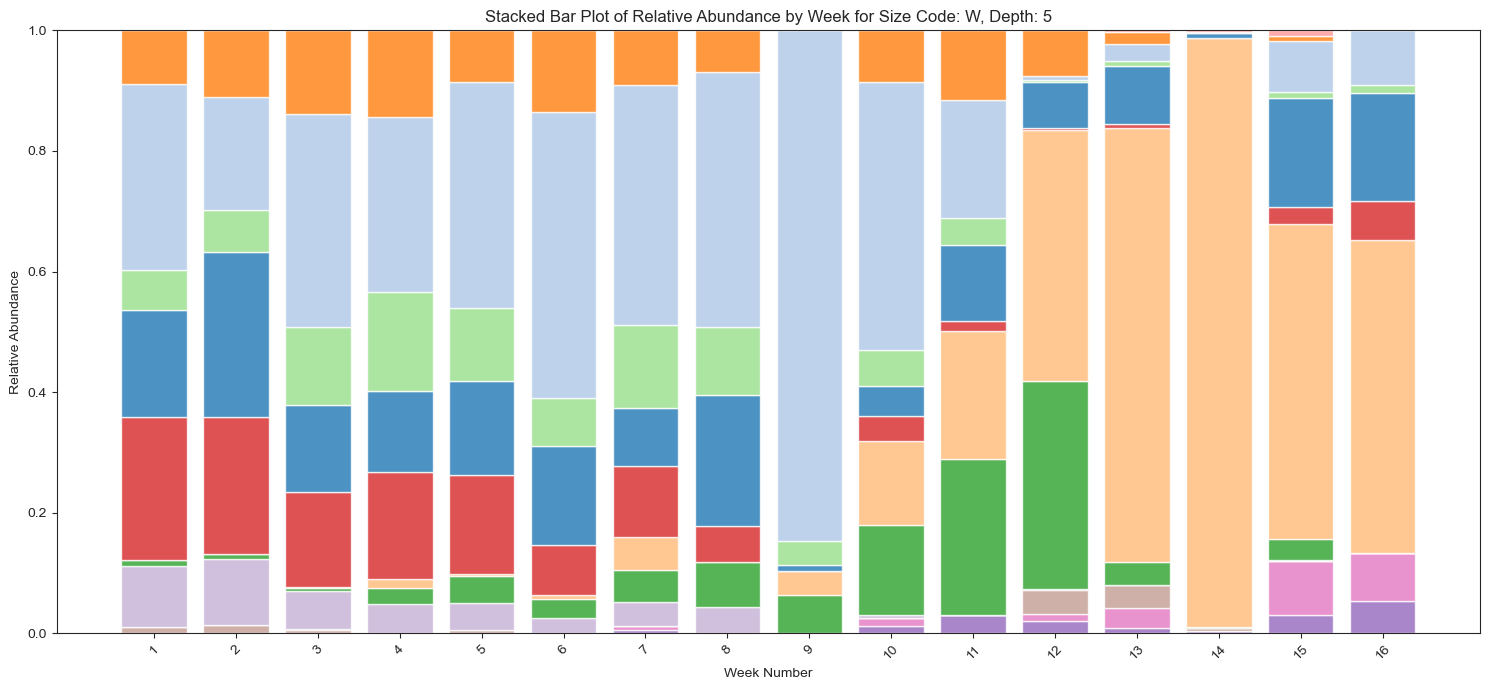

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


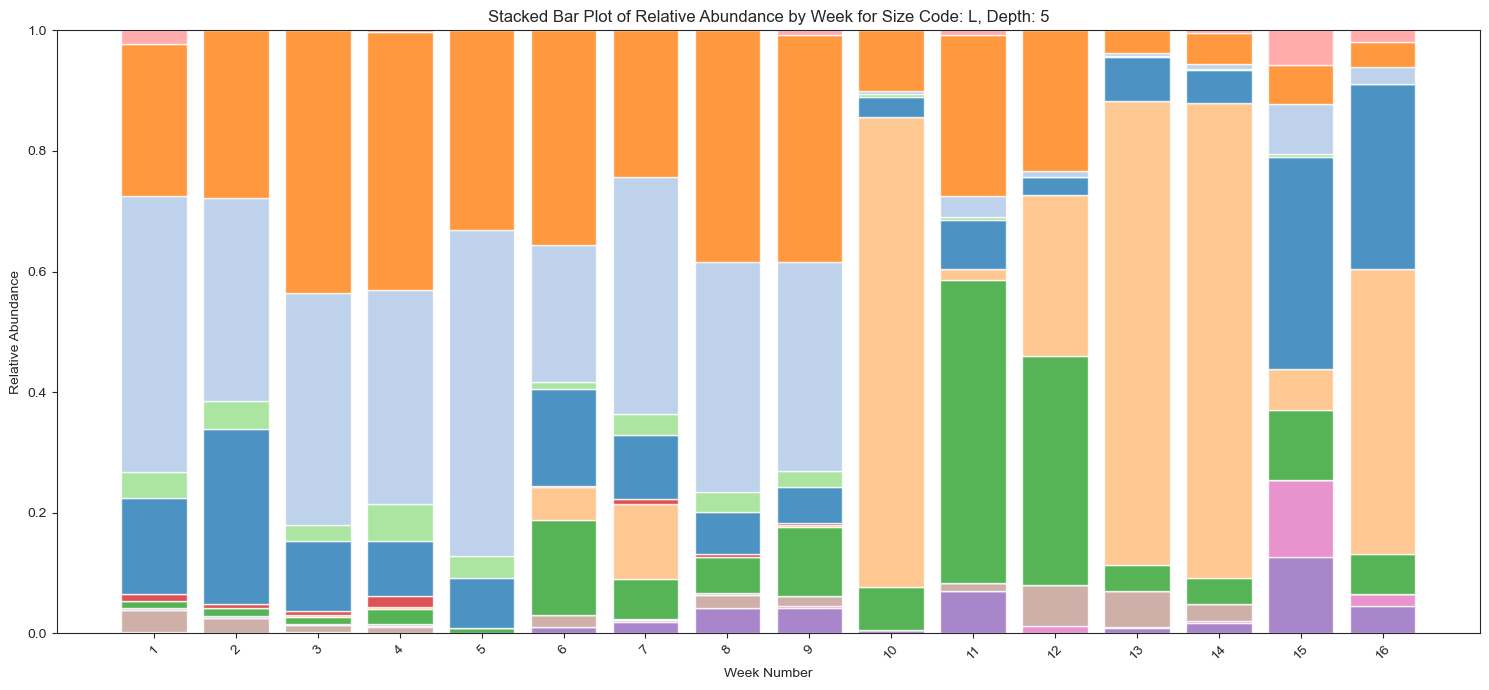

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


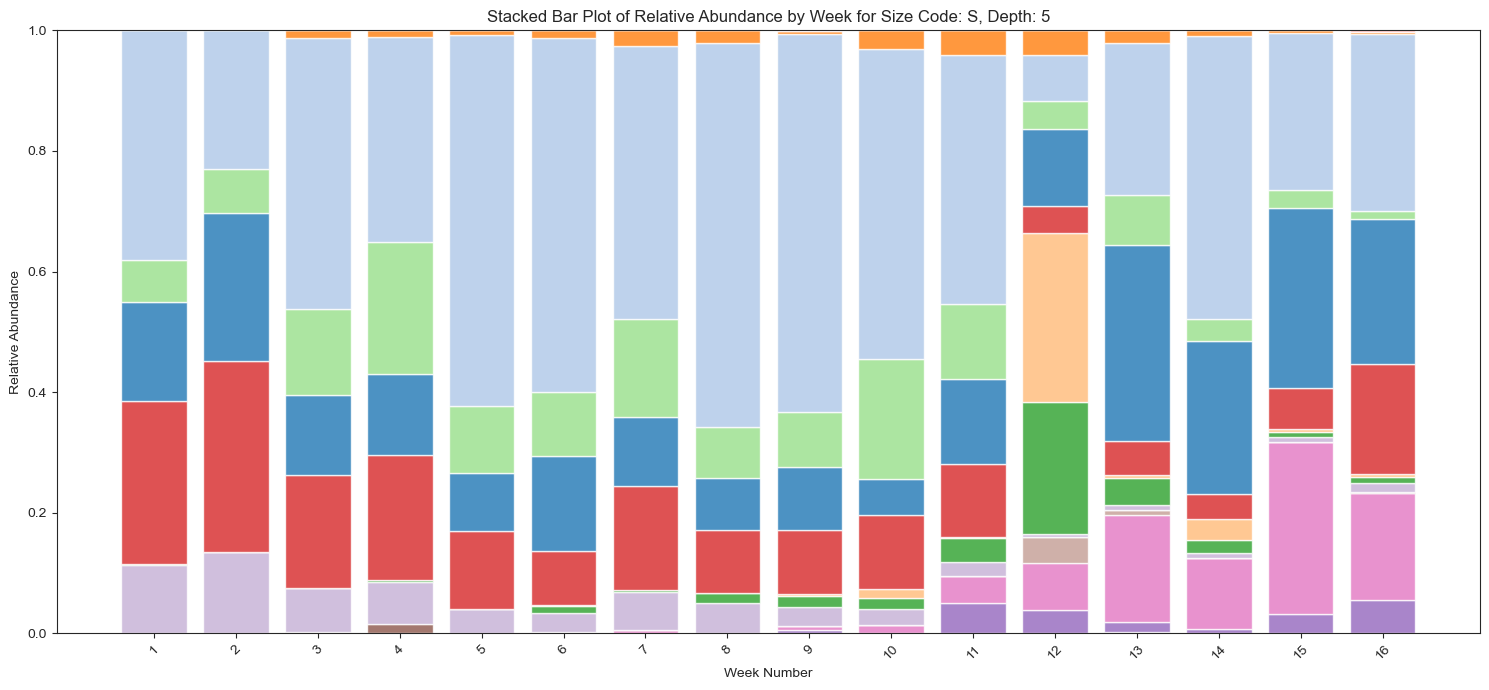

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


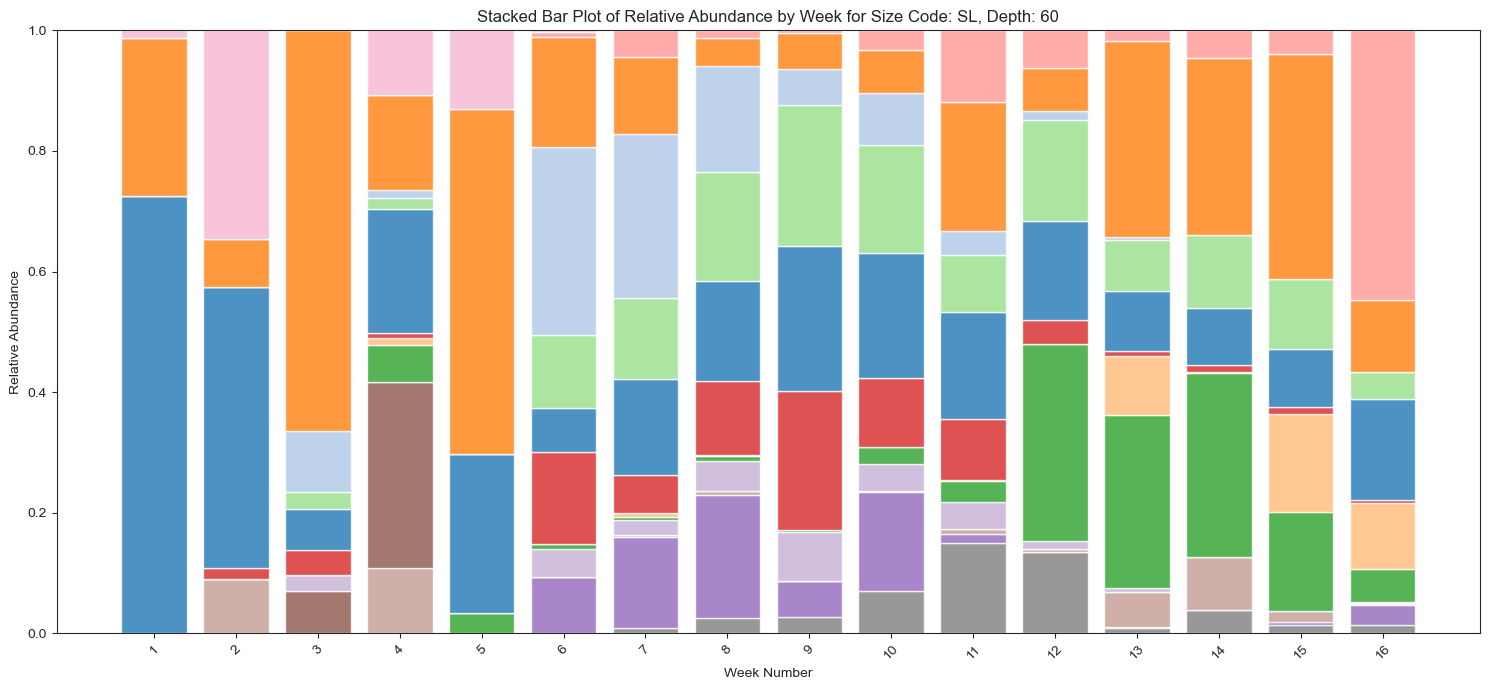

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


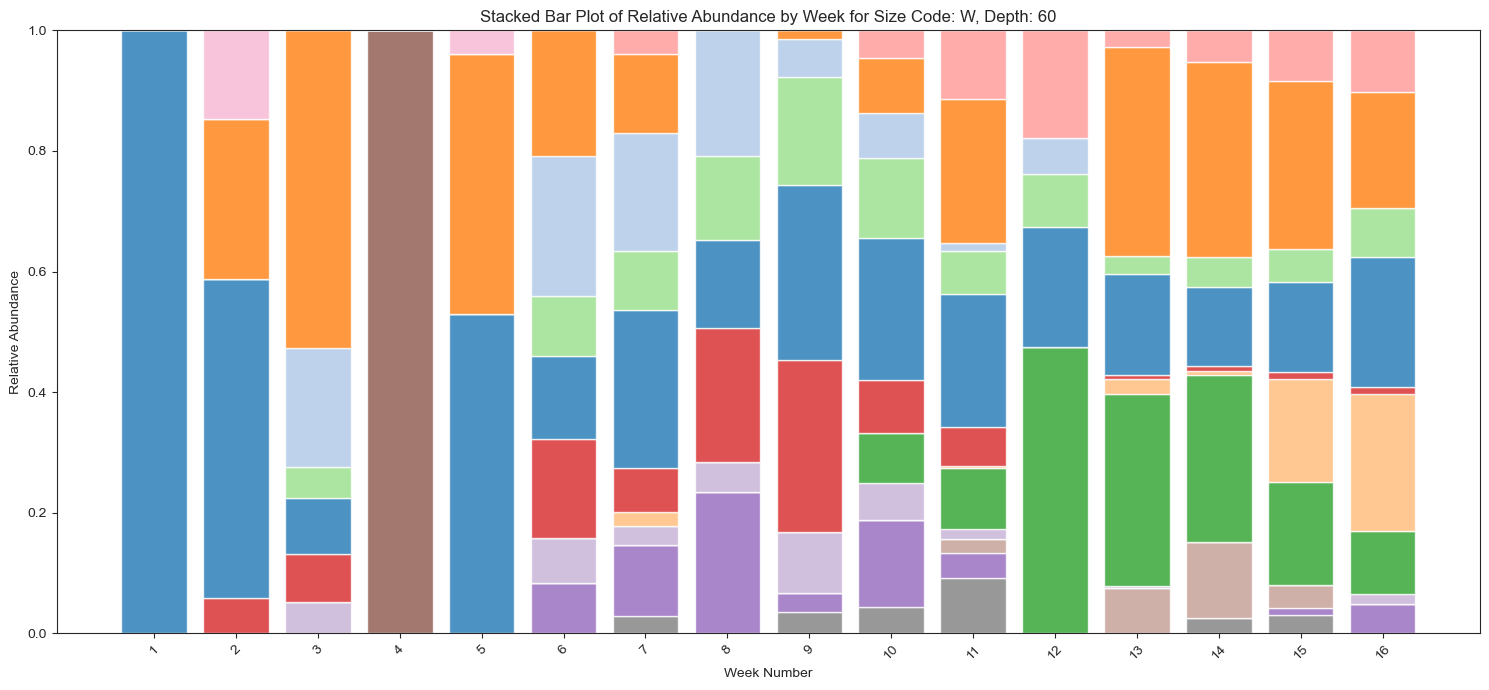

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


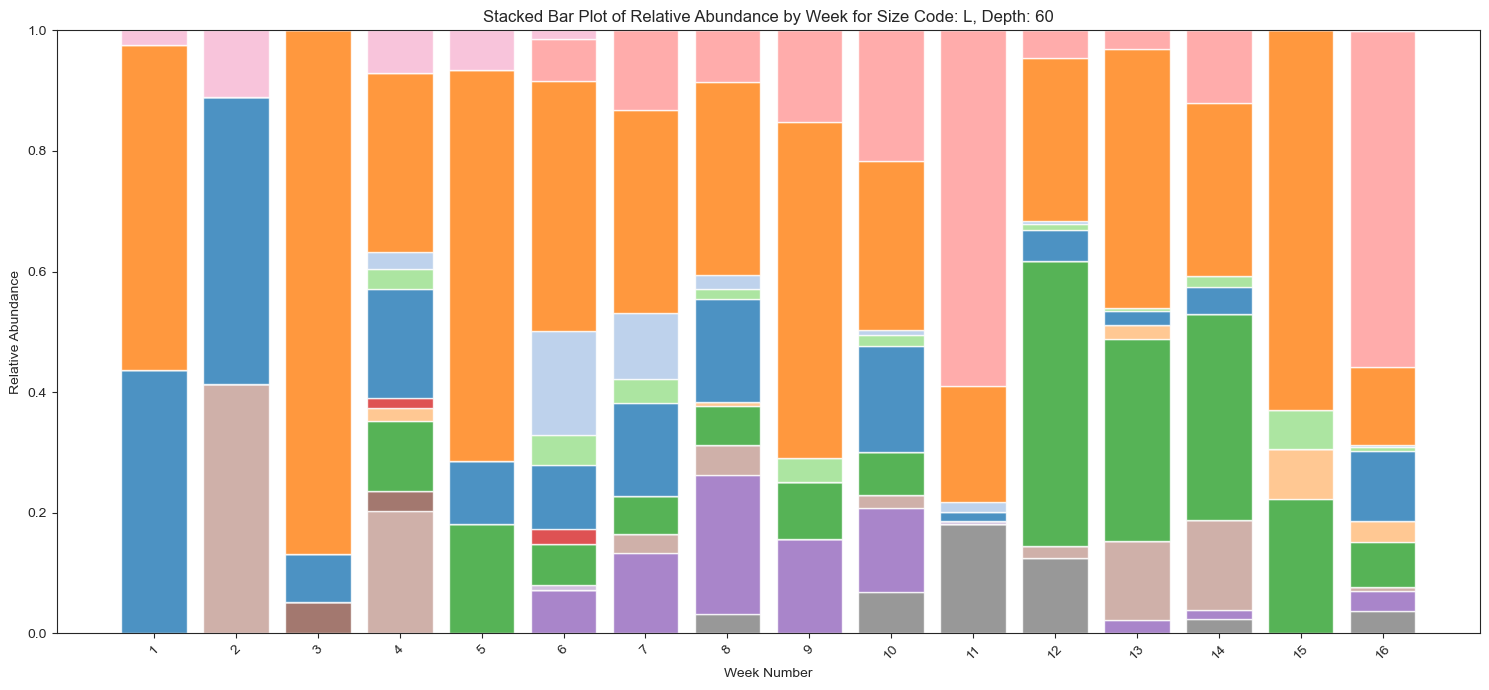

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


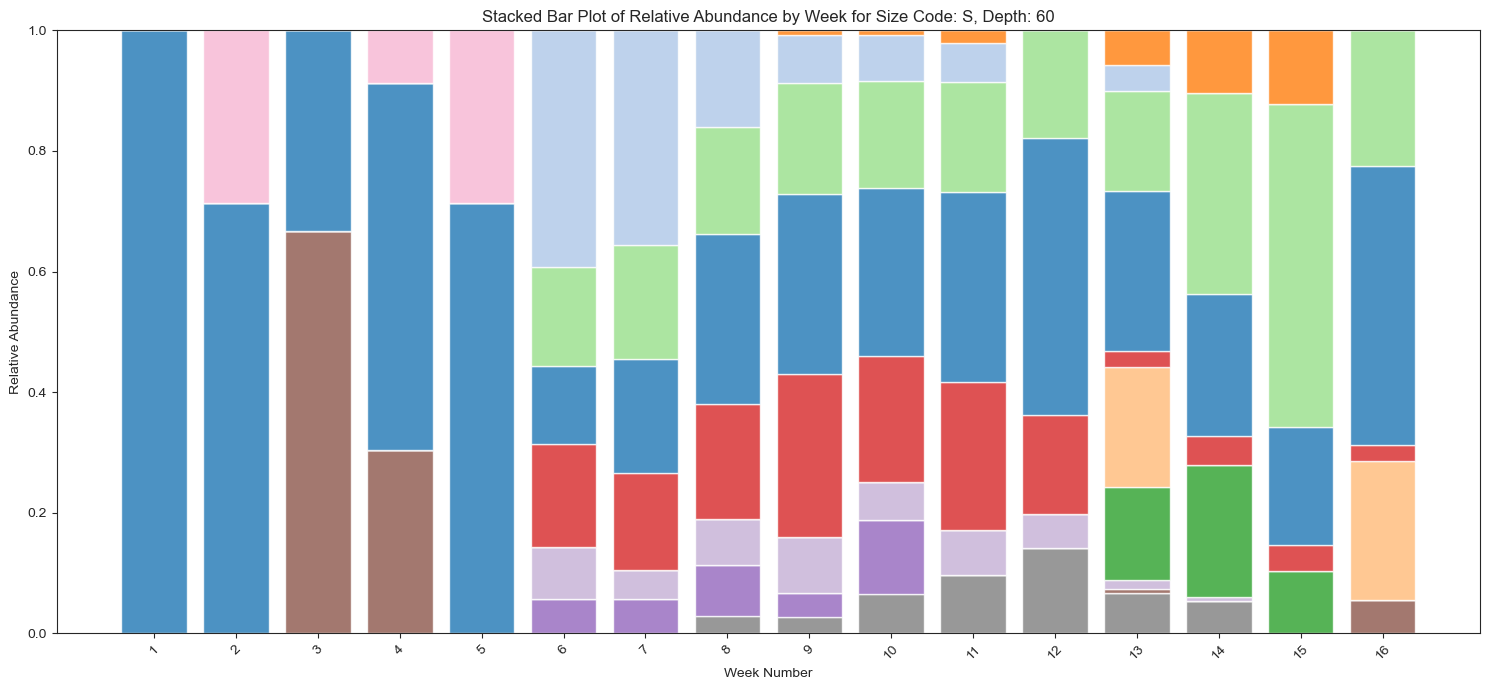

<Figure size 1000x100 with 0 Axes>

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Assuming 'newseparated' DataFrame has been loaded with columns 'size_code', 'depth', 'Taxon', 'weekn', 'Class', 'ratio', 'feature_id'

depths = [5, 60]  # Depths to plot
level = 'Class'

if comm == 'chloroplast':
    level = 'PRSpecies'

# Filter data for the relevant depths
sfd_all = newseparated[newseparated['depth'].isin(depths)]

# Replace "Unassigned" or "uncultured+bacterium" at the given level with its 'feature_id'
sfd_all[level] = sfd_all.apply(
    lambda row: row['feature_id'] if row[level] in ['Unassigned', 'uncultured+bacterium'] else row[level],
    axis=1
)

# Aggregate data globally to find the most abundant taxa across all depths
global_abundance = sfd_all.groupby(level)['ratio'].sum().sort_values(ascending=False)

# Select the top 14 most abundant taxa globally
top_taxa = global_abundance.head(14).index.tolist()

# Create a new column to group less abundant taxa into "Other"
sfd_all['plot_taxa'] = sfd_all[level].apply(lambda x: x if x in top_taxa else 'Other')

# Create a global discrete color palette for taxa
unique_taxa = ['Other'] + top_taxa  # Ensure "Other" is always included and listed first
n_taxa = len(unique_taxa)

# Use a categorical colormap with up to 15 unique colors
color_palette = plt.get_cmap('tab20').colors  # tab20 provides up to 20 colors
color_dict = {taxon: color_palette[i % len(color_palette)] for i, taxon in enumerate(unique_taxa)}

# Generate plots for each depth
for depth in depths:
    sfd = sfd_all[sfd_all['depth'] == depth]
    size_codes = sfd['size_code'].unique()

    for idx, size_code in enumerate(size_codes):
        # Filter data for the current size_code
        top10d = sfd[sfd['size_code'] == size_code].copy()
        phyld = top10d.groupby(['weekn', 'plot_taxa'])['ratio'].sum().reset_index()
        
        # Pivot the DataFrame to prepare for stacked bar plotting
        phyld_pivot = phyld.pivot(index='weekn', columns='plot_taxa', values='ratio').fillna(0).reset_index()
        
        # Determine x positions based on unique week numbers
        week_numbers = phyld_pivot['weekn'].unique()
        x = np.arange(len(week_numbers))  # Positions for bars

        # Initialize stack heights
        bottom_stack = np.zeros(len(x))

        # Initialize the plot
        fig, ax1 = plt.subplots(figsize=(15, 7))

        # Iterate over each taxon and stack their relative abundances
        taxa_categories = phyld_pivot.columns[1:]  # Skip 'weekn'
        for taxon in taxa_categories:
            # Aggregate taxon values by week
            heights = phyld_pivot.groupby('weekn')[taxon].sum().reindex(week_numbers, fill_value=0).values

            # Plot the stacked bar for this taxon
            ax1.bar(
                x,  # X positions
                heights,  # Heights of the bars
                bottom=bottom_stack,  # Start at the current stack height
                alpha=0.8,
                color=color_dict.get(taxon, 'gray')  # Use color from dictionary or default to gray
            )
            # Update the stack height
            bottom_stack += heights

        # Customize x-axis
        ax1.set_xticks(x)
        ax1.set_xticklabels(week_numbers, rotation=45)
        ax1.set_ylabel("Relative Abundance")
        ax1.set_xlabel("Week Number")

        # Do not add any legends to individual plots
        ax1.legend().remove()

        # Display the plot
        plt.title(f"Stacked Bar Plot of Relative Abundance by Week for Size Code: {size_code}, Depth: {depth}")
        plt.tight_layout()
        plt.savefig(f'outputs/{comm}/stacked_bar_plot_size_code_{size_code}_depth_{depth}.png', dpi=300, bbox_inches='tight')
        plt.show()

# Create a single legend figure for all depths
fig_legend = plt.figure(figsize=(10, 1))
legend_handles = [
    plt.Line2D([0], [0], color=color_dict[taxon], lw=10, label=taxon)
    for taxon in unique_taxa
]
fig_legend.legend(
    handles=legend_handles,
    loc="center",
    ncol=5,
    title="Taxa"
)
plt.tight_layout()
plt.savefig(f"outputs/{comm}/legend_for_all_depths.png", dpi=300, bbox_inches='tight')
plt.show()


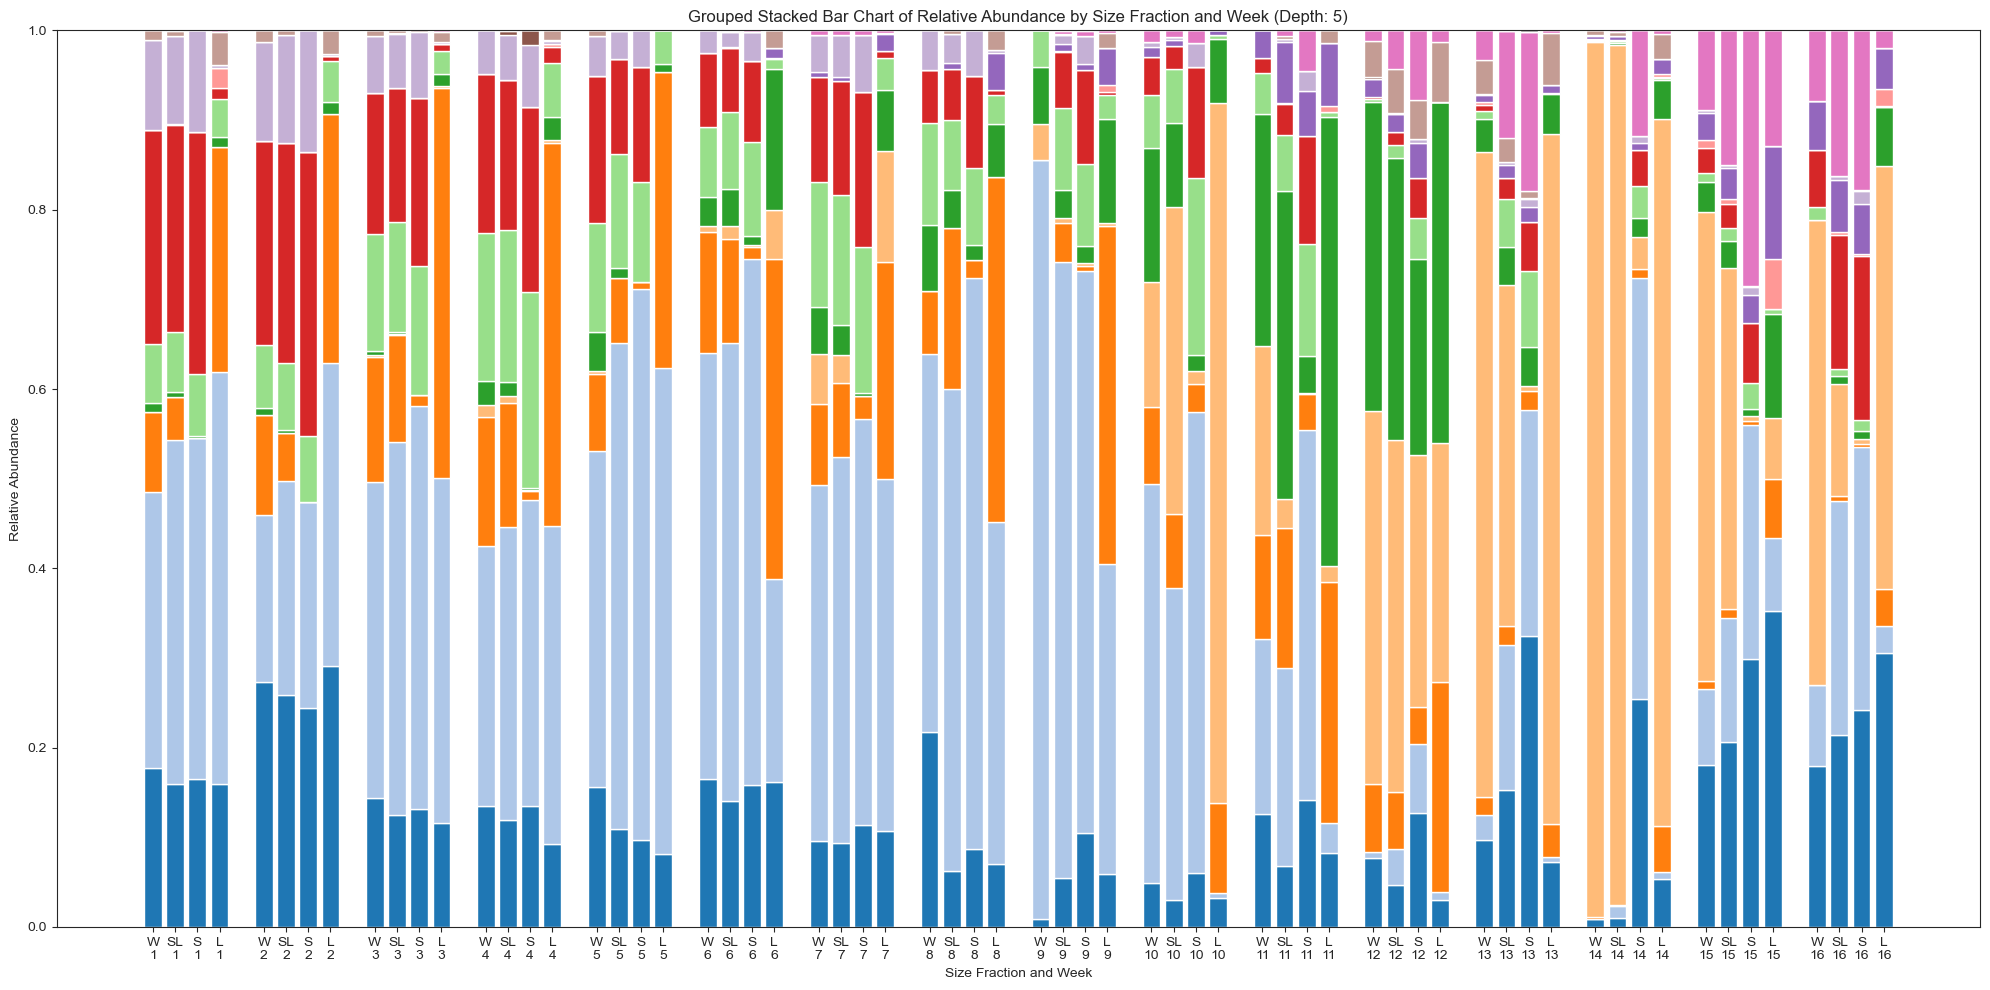

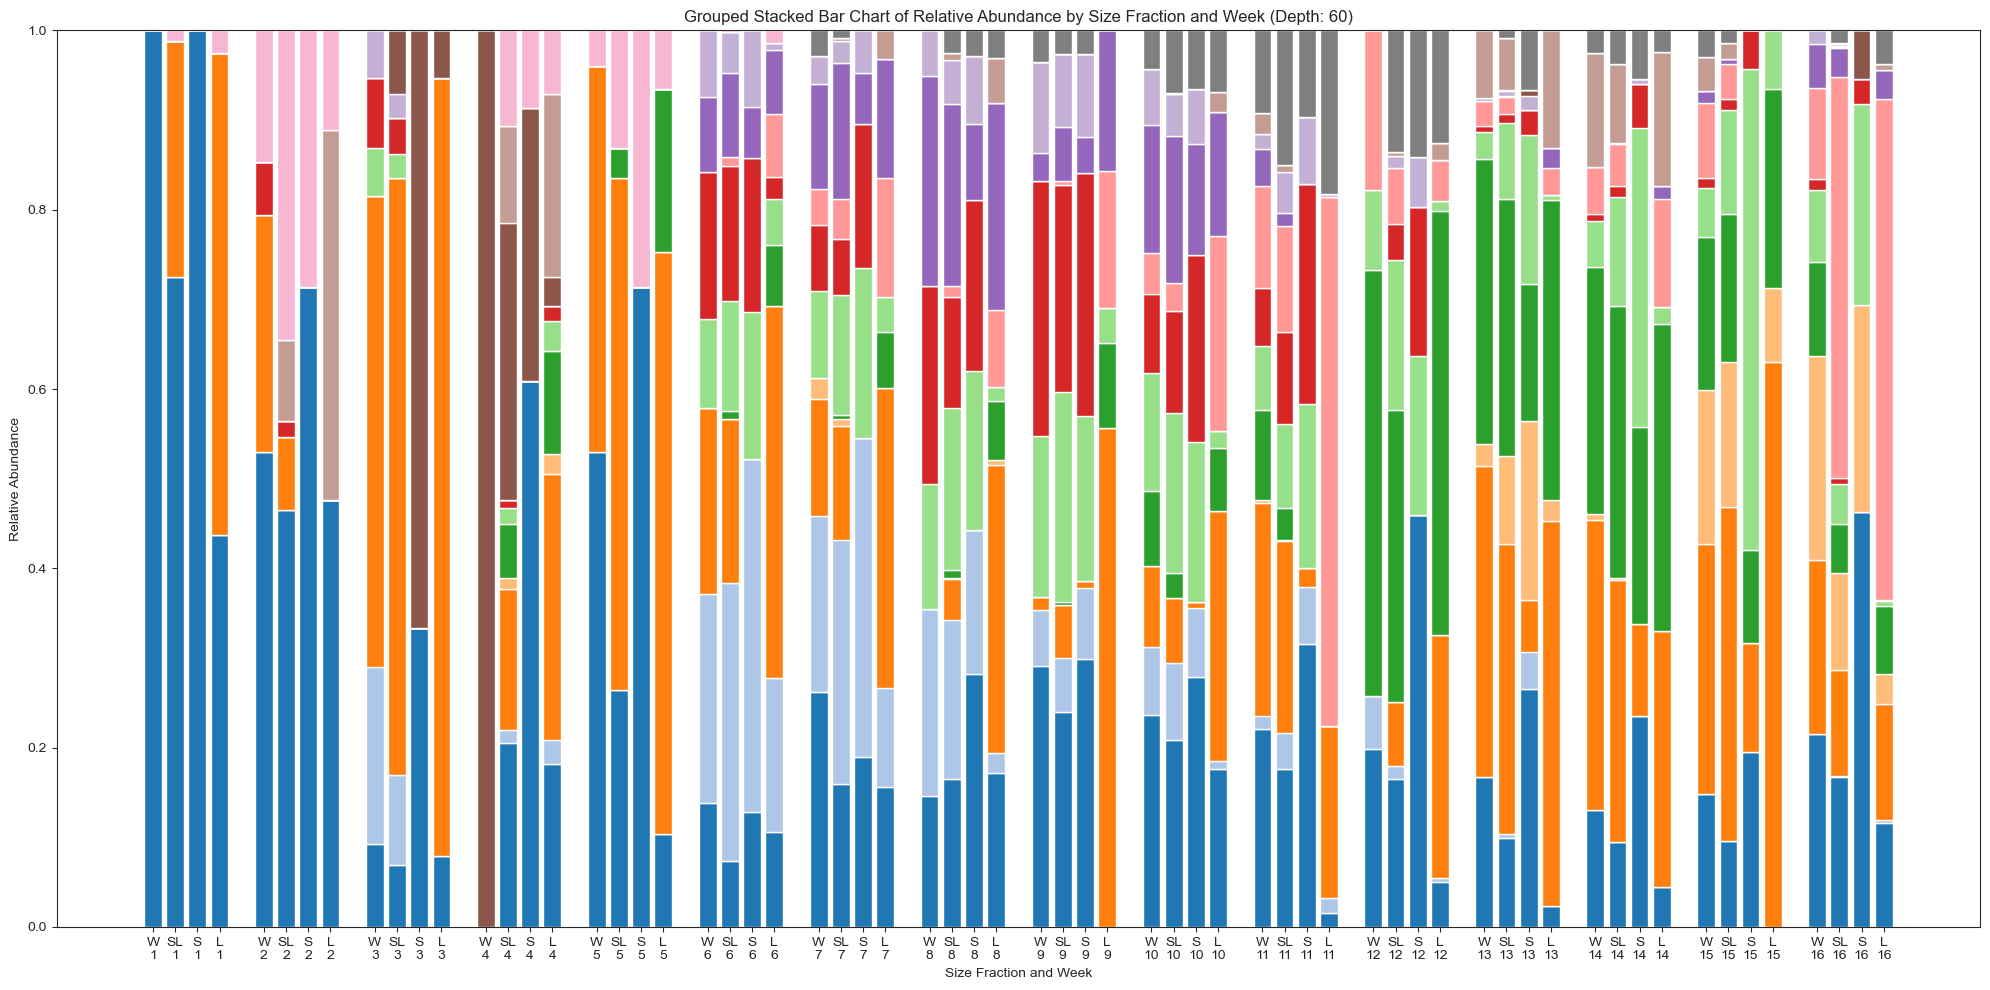

<Figure size 1000x100 with 0 Axes>

In [67]:
# Aggregate data globally to find the most abundant taxa across all depths
global_abundance = sfd_all.groupby(level)['ratio'].sum().sort_values(ascending=False)

# Select the top 14 most abundant taxa globally
top_taxa = global_abundance.head(14).index.tolist()

# Create a new column to group less abundant taxa into "Other"
sfd_all['plot_taxa'] = sfd_all[level].apply(lambda x: x if x in top_taxa else 'Other')

# Create a global discrete color palette for taxa
unique_taxa = ['Other'] + top_taxa  # Ensure "Other" is always included and listed first
n_taxa = len(unique_taxa)

# Use a categorical colormap with up to 15 unique colors
color_palette = plt.get_cmap('tab20').colors  # tab20 provides up to 20 colors
color_dict = {taxon: color_palette[i % len(color_palette)] for i, taxon in enumerate(unique_taxa)}

# Generate grouped stacked bar charts for all size codes combined at each depth
for depth in depths:
    sfd = sfd_all[sfd_all['depth'] == depth]

    # Aggregate by weekn, size_code, and plot_taxa
    grouped = sfd.groupby(['weekn', 'size_code', 'plot_taxa'])['ratio'].sum().reset_index()

    # Pivot data to prepare for grouped stacked bar chart
    pivot_grouped = grouped.pivot(index=['weekn', 'size_code'], columns='plot_taxa', values='ratio').fillna(0)

    # Reverse alphabetical order for size codes
    size_codes = sorted(sfd['size_code'].unique(), reverse=True)
    weeks = sorted(sfd['weekn'].unique())

    # Calculate x positions with increased spacing for weeks
    week_gap = len(size_codes) + 1  # Larger gap between weeks
    x_positions = []
    group_labels = []
    for i, week in enumerate(weeks):
        for j, size_code in enumerate(size_codes):
            x_positions.append(i * week_gap + j)  # Position for each size code within a week
            group_labels.append(f"{size_code}\n{week}")

    # Initialize the plot
    fig, ax = plt.subplots(figsize=(20, 10))

    # Initialize stack heights
    bottom_stack = np.zeros(len(x_positions))

    # Iterate over taxa for stacking
    for taxon in unique_taxa:
        heights = []
        for week in weeks:
            for size_code in size_codes:
                try:
                    heights.append(pivot_grouped.loc[(week, size_code), taxon])
                except KeyError:
                    heights.append(0)
        ax.bar(
            x_positions,
            heights,
            width=0.8,  # Fixed width for grouped bars
            bottom=bottom_stack,
            label=taxon,
            color=color_dict[taxon]
        )
        bottom_stack += np.array(heights)

    # Customize x-axis and legend
    ax.set_xticks([i * week_gap + len(size_codes) / 2 - 0.5 for i in range(len(weeks))])  # Tick for each week group
    ax.set_xticklabels([f"{week}" for week in weeks], rotation=0, ha='center')
    ax.set_ylabel("Relative Abundance")
    ax.set_xlabel("Size Fraction and Week")
    ax.set_title(f"Grouped Stacked Bar Chart of Relative Abundance by Size Fraction and Week (Depth: {depth})")

    # Annotate each column with its size_code and week number
    ax.set_xticks(x_positions)  # Set ticks for every bar
    ax.set_xticklabels(group_labels, rotation=0, ha="center")

    # Save and show the grouped stacked bar chart
    plt.tight_layout()
    plt.savefig(f'grouped_stacked_bar_chart_depth_{depth}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create a single legend figure for all depths
fig_legend = plt.figure(figsize=(10, 1))
legend_handles = [
    plt.Line2D([0], [0], color=color_dict[taxon], lw=10, label=taxon)
    for taxon in unique_taxa
]
fig_legend.legend(
    handles=legend_handles,
    loc="center",
    ncol=5,
    title="Taxa"
)
plt.tight_layout()
plt.savefig("legend_for_all_depths.png", dpi=300, bbox_inches='tight')
plt.show()
